# Precipitation Histograms

By: Ty Janoski

## Import statements

In [2]:
# import statements
import dask
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np

# Configurations
plt.style.use("dark_background")
dask.config.set({"array.slicing.split_large_chunks": False}) # type: ignore

## Read in Data

In [3]:
def load_data(init: str, keyword: str) -> xr.Dataset:

    # Note that this function depends on a consistent file structure so if you
    # change that, you'll need to change this function.
    # First, determine starting date
    start_date = "2021-09-02" if init in ["00Z", "01Z"] else "2021-09-01"
    new_dates = xr.date_range(
        start=start_date + " " + init[:-1] + ":00:00",
        end="2021-09-02 " + str((int(init[:-1]) + 6) % 24).zfill(2) + ":00:00",
        freq="5min",
        use_cftime=True,
    )

    # read in data
    data = xr.open_mfdataset(
        "/mnt/drive2/wof-runs/post-processed/"
        + init
        + "/wofs_"
        + keyword.upper()
        + "*.nc",
        concat_dim="time",
        combine="nested",
        parallel=True,
    )
    data["time"] = new_dates
    return data

In [4]:
ens = [load_data(i, "ens") for i in ["20Z", "21Z", "22Z", "23Z", "00Z", "01Z"]]
ens = [e.assign_coords(lat=e.lat, lon=e.lon, ne=e.ne) for e in ens]

# Make a new DataArray
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z", "00Z", "01Z"], dims="init")
init = init.assign_coords({"init": init})

# concat
ens = xr.concat(ens, dim=init).chunk({"init": 1, "time": -1})

## Find the point closest to Central Park

In [5]:
# Set desired latitude and longitude
# Central Park: 40.7826° N, 73.9656° W
nyc_lat, nyc_lon = 40.7826, -73.9656

# Isolate XLAT and XLONG for ease of use
lat = ens.xlat.isel(time=0,init=0)
lon = ens.xlon.isel(time=0,init=0)

# Calculate the Euclidean distance between lat and lon values and the desired point
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)

# Find where the distance is minimized
nyc_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])

## Calculate 1-hour accumulated rainfall for 1-2Z

In [6]:
# Compute the 1-hour accumulated rainfall for 01–02 UTC
rain_0102 = ens.rain.sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00")).sum(
    dim="time"
)

# Take area average in 48km x 48km box centered at central park
rain_0102_nyc = rain_0102.isel(
    lat=slice(lat_ind - 8, lat_ind + 8), lon=slice(lon_ind - 8, lon_ind + 8)
).mean(dim=("lat", "lon"))

## Make Histogram

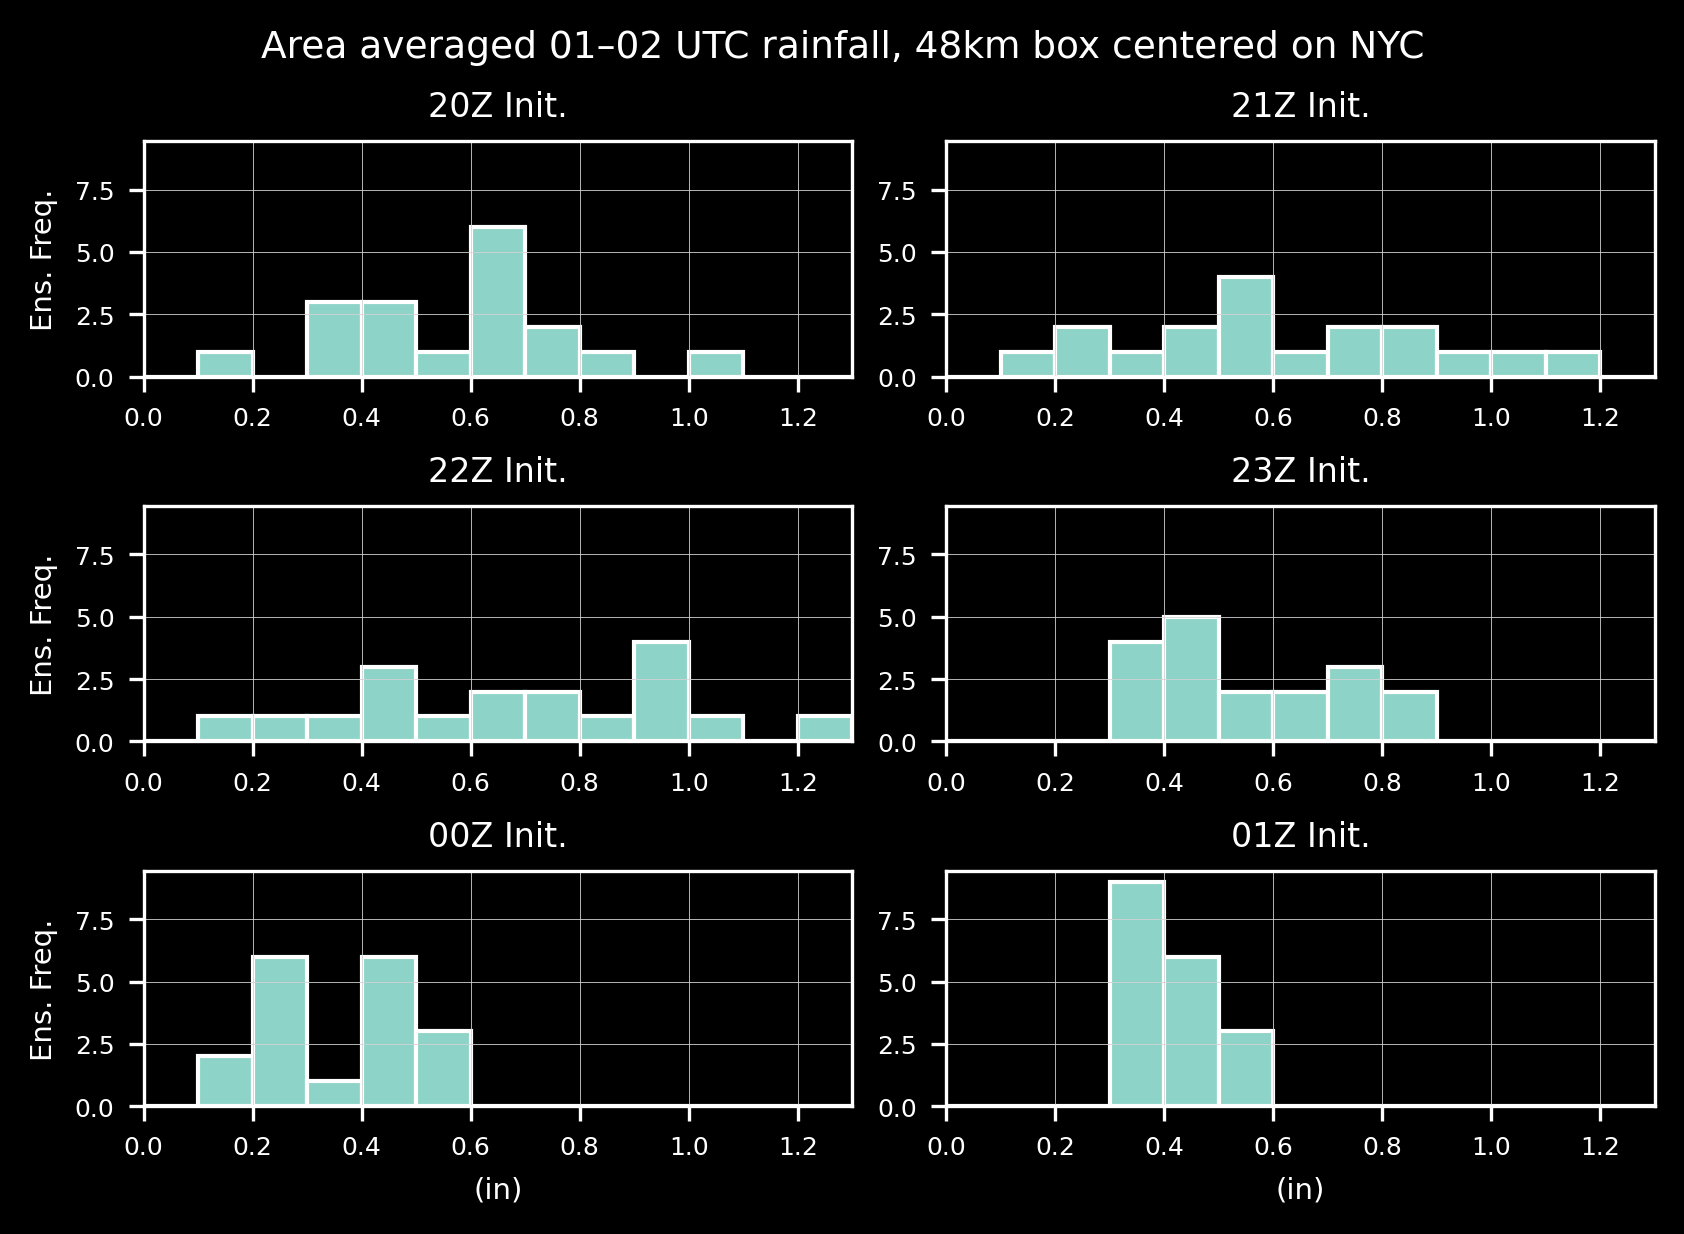

In [8]:
# Make a list of titles
titles = ["20Z Init.", "21Z Init.", "22Z Init.", "23Z Init.", "00Z Init.", "01Z Init."]

# Make a 3 x 2 figure with a histogram of 1-2 UTC rainfall for each initialization
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    sharex=True,
    sharey=True,
    dpi=300,
    layout="constrained",
    figsize=(5.5, 4),
)

# Loop through each initialization
for i, ax in enumerate(axes.flatten()):
    # Plot the histogram
    rain_0102_nyc.isel(init=i).plot.hist(
        ax=ax, edgecolor="white", bins=np.arange(0, 1.4, 0.1)
    )

    ax.xaxis.set_tick_params(which="both", labelbottom=True)
    ax.tick_params(axis="both", labelsize=6)
    ax.set_xticks(np.arange(0, 1.4, 0.2))
    ax.yaxis.set_tick_params(which="both", labelleft=True)
    ax.grid(color="lightgray", linewidth=0.2)
    ax.set_title(titles[i], fontsize=8)
    ax.set_xlabel("")

    if i % 2 == 0:
        ax.set_ylabel("Ens. Freq.", fontsize=7)

axes[2, 1].set_xlabel("(in)", fontsize=7)
axes[2, 0].set_xlabel("(in)", fontsize=7)

plt.xlim(0, 1.3)

plt.suptitle("Area averaged 01–02 UTC rainfall, 48km box centered on NYC", fontsize=9)
plt.show()

# Old code

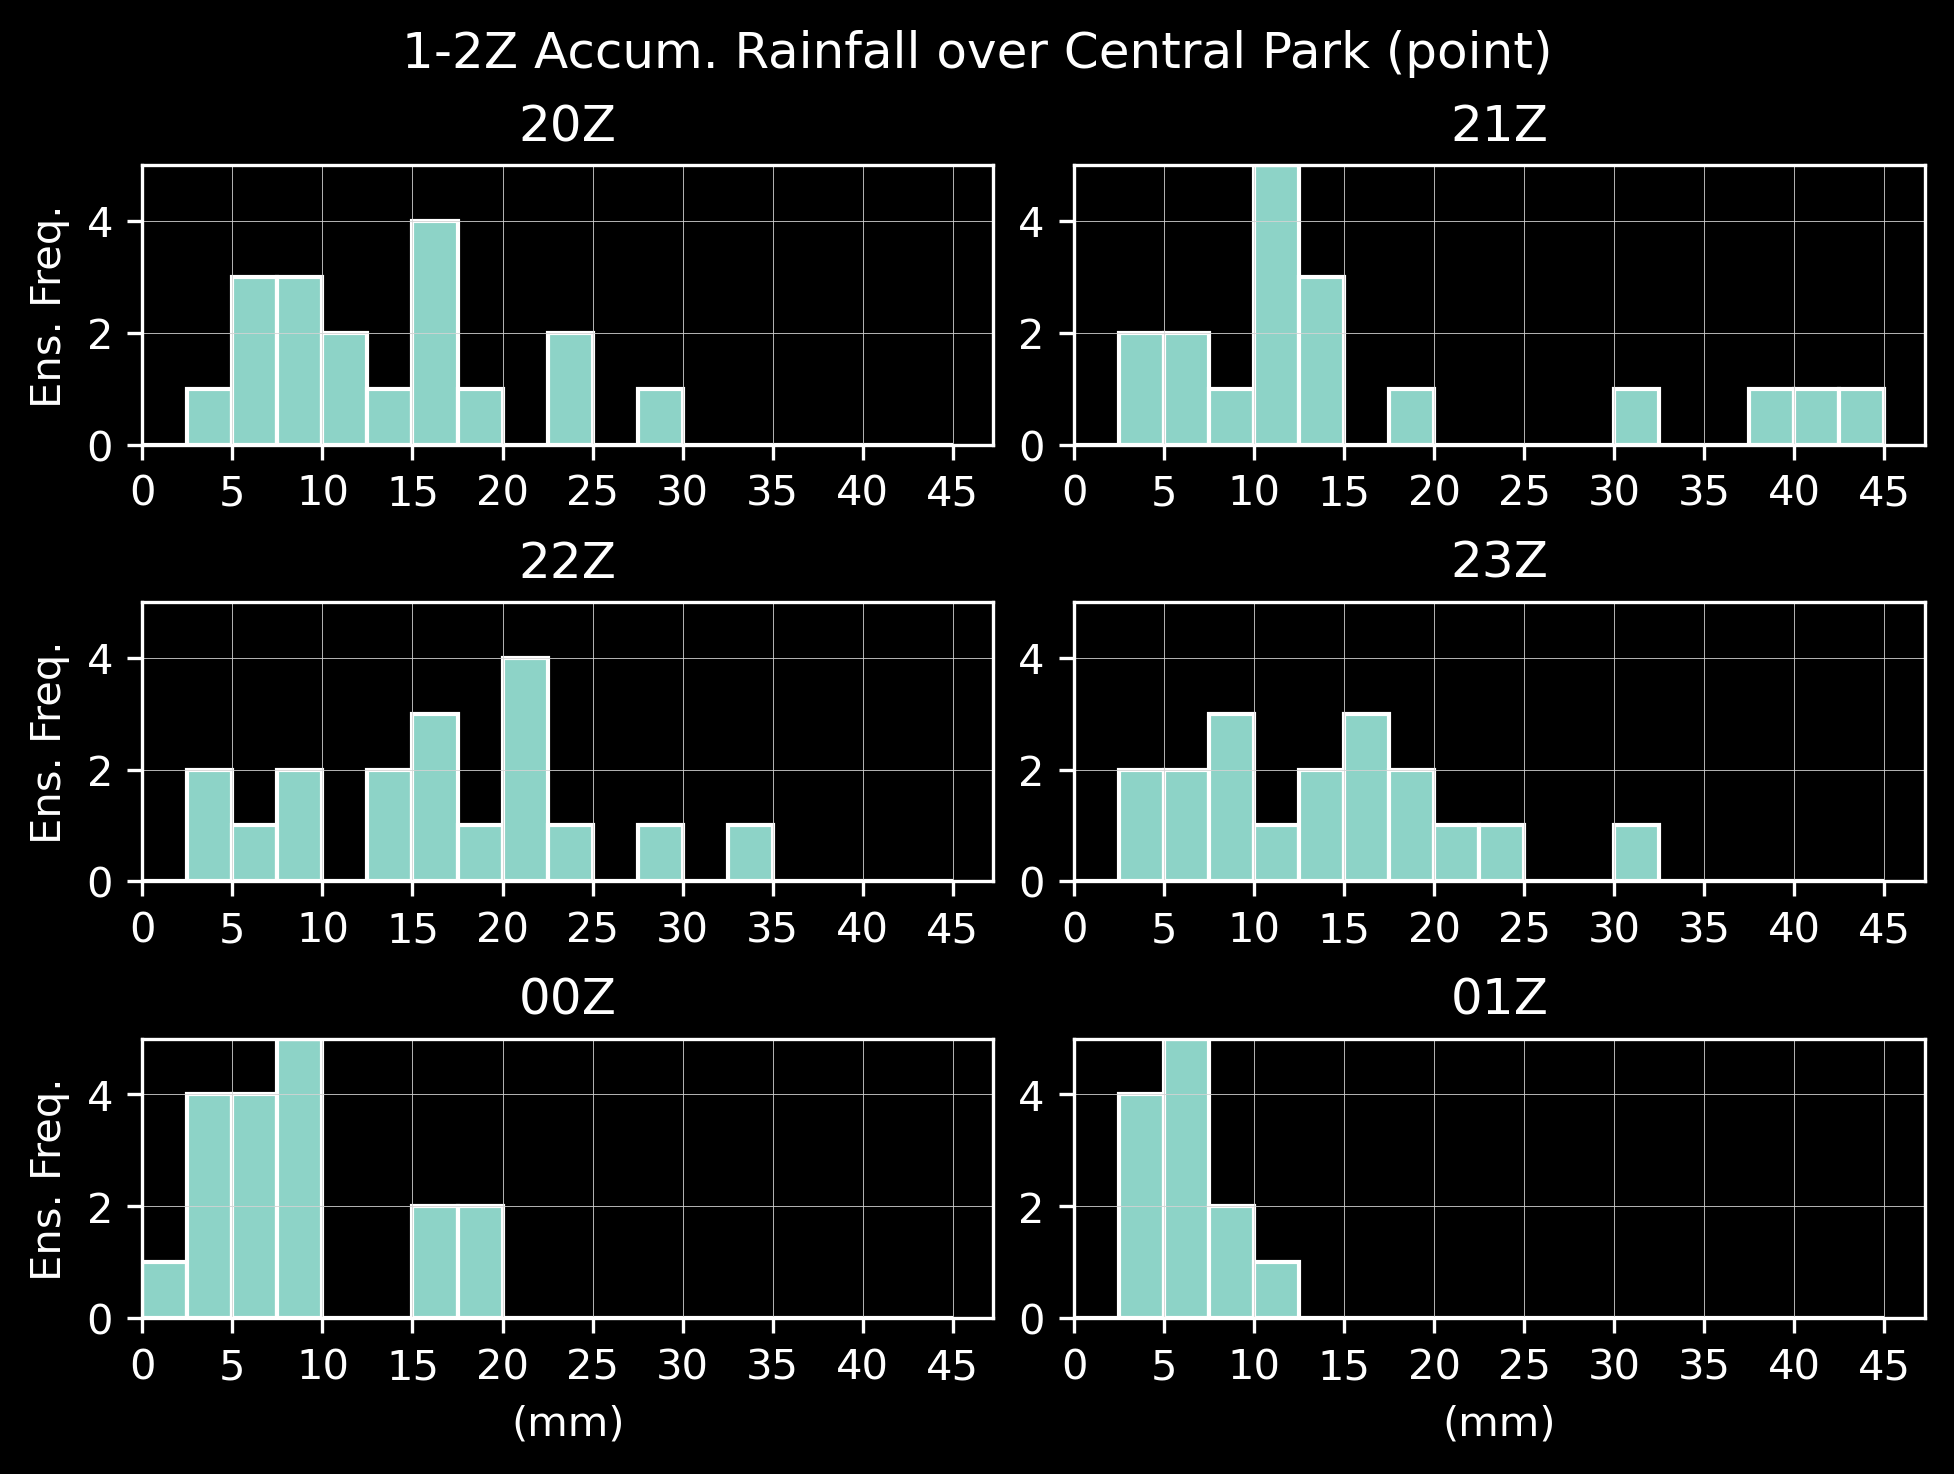

In [25]:
data_to_plot = [rainy_hour_20Z,rainy_hour_21Z,rainy_hour_22Z,
                rainy_hour_23Z,rainy_hour_00Z,rainy_hour_01Z]
titles = ["20Z","21Z","22Z","23Z","00Z","01Z"]
bin_edges = np.arange(0,45.1,2.5)

plt.style.use("dark_background")

fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,
                        dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    xr.plot.hist(data_to_plot[i],ax=ax,edgecolor='white',bins=bin_edges)
    ax.xaxis.set_tick_params(which='both',labelbottom=True)
    ax.set_xticks(np.arange(0,46,5))
    ax.yaxis.set_tick_params(which='both',labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_title(titles[i])
    ax.set_xlabel("")
    if(i%2==0):
        ax.set_ylabel("Ens. Freq.")
# xr.plot.hist(rainy_hour_20Z,ax=axes[0],edgecolor='white',bins=bin_edges)
# axes[0].xaxis.set_tick_params(which='both',labelbottom=True)

# xr.plot.hist(rainy_hour_22Z,ax=axes[1],edgecolor='white',bins=bin_edges)

# axes.flatten()[-1].set_visible(False)
axes[2,1].set_xlabel("(mm)")
axes[2,0].set_xlabel("(mm)")

plt.ylim(0,5)
plt.xlim(0,)

plt.suptitle("1-2Z Accum. Rainfall over Central Park (point)")
plt.show()

## Take average of 3x3 or 5x5 grid box area around Central Park

In [22]:
# Grab the points either one or two away from our central park point

# I'm tired of making new variables so we are just gonna use a list
rainnc = [r.RAINNC for r in [rainnc_20Z,rainnc_21Z,rainnc_22Z,rainnc_23Z,
rainnc_00Z,rainnc_01Z]]

# There's a lot going on next, but we are basically slicing the data to include the
# points on either side of our central point.
rainnc_3x3 = [r.isel(south_north=slice(int(nyc_inds["south_north"]-1),
                                      int(nyc_inds["south_north"]+2))).isel(
                                          west_east=slice(int(nyc_inds["west_east"]-1),
                                                          int(nyc_inds["west_east"]+2))
                                      ) for r in rainnc]

rainnc_5x5 = [r.isel(south_north=slice(int(nyc_inds["south_north"]-2),
                                      int(nyc_inds["south_north"]+3))).isel(
                                          west_east=slice(int(nyc_inds["west_east"]-2),
                                                          int(nyc_inds["west_east"]+3))
                                      ) for r in rainnc]

# now take the area average and feed into the 1 hr accum function
rainy_hours_3x3 = [get_1Z_to_2Z(
    r.mean(dim=["south_north","west_east"])) for r in rainnc_3x3]

rainy_hours_5x5 = [get_1Z_to_2Z(
    r.mean(dim=["south_north","west_east"])) for r in rainnc_5x5]

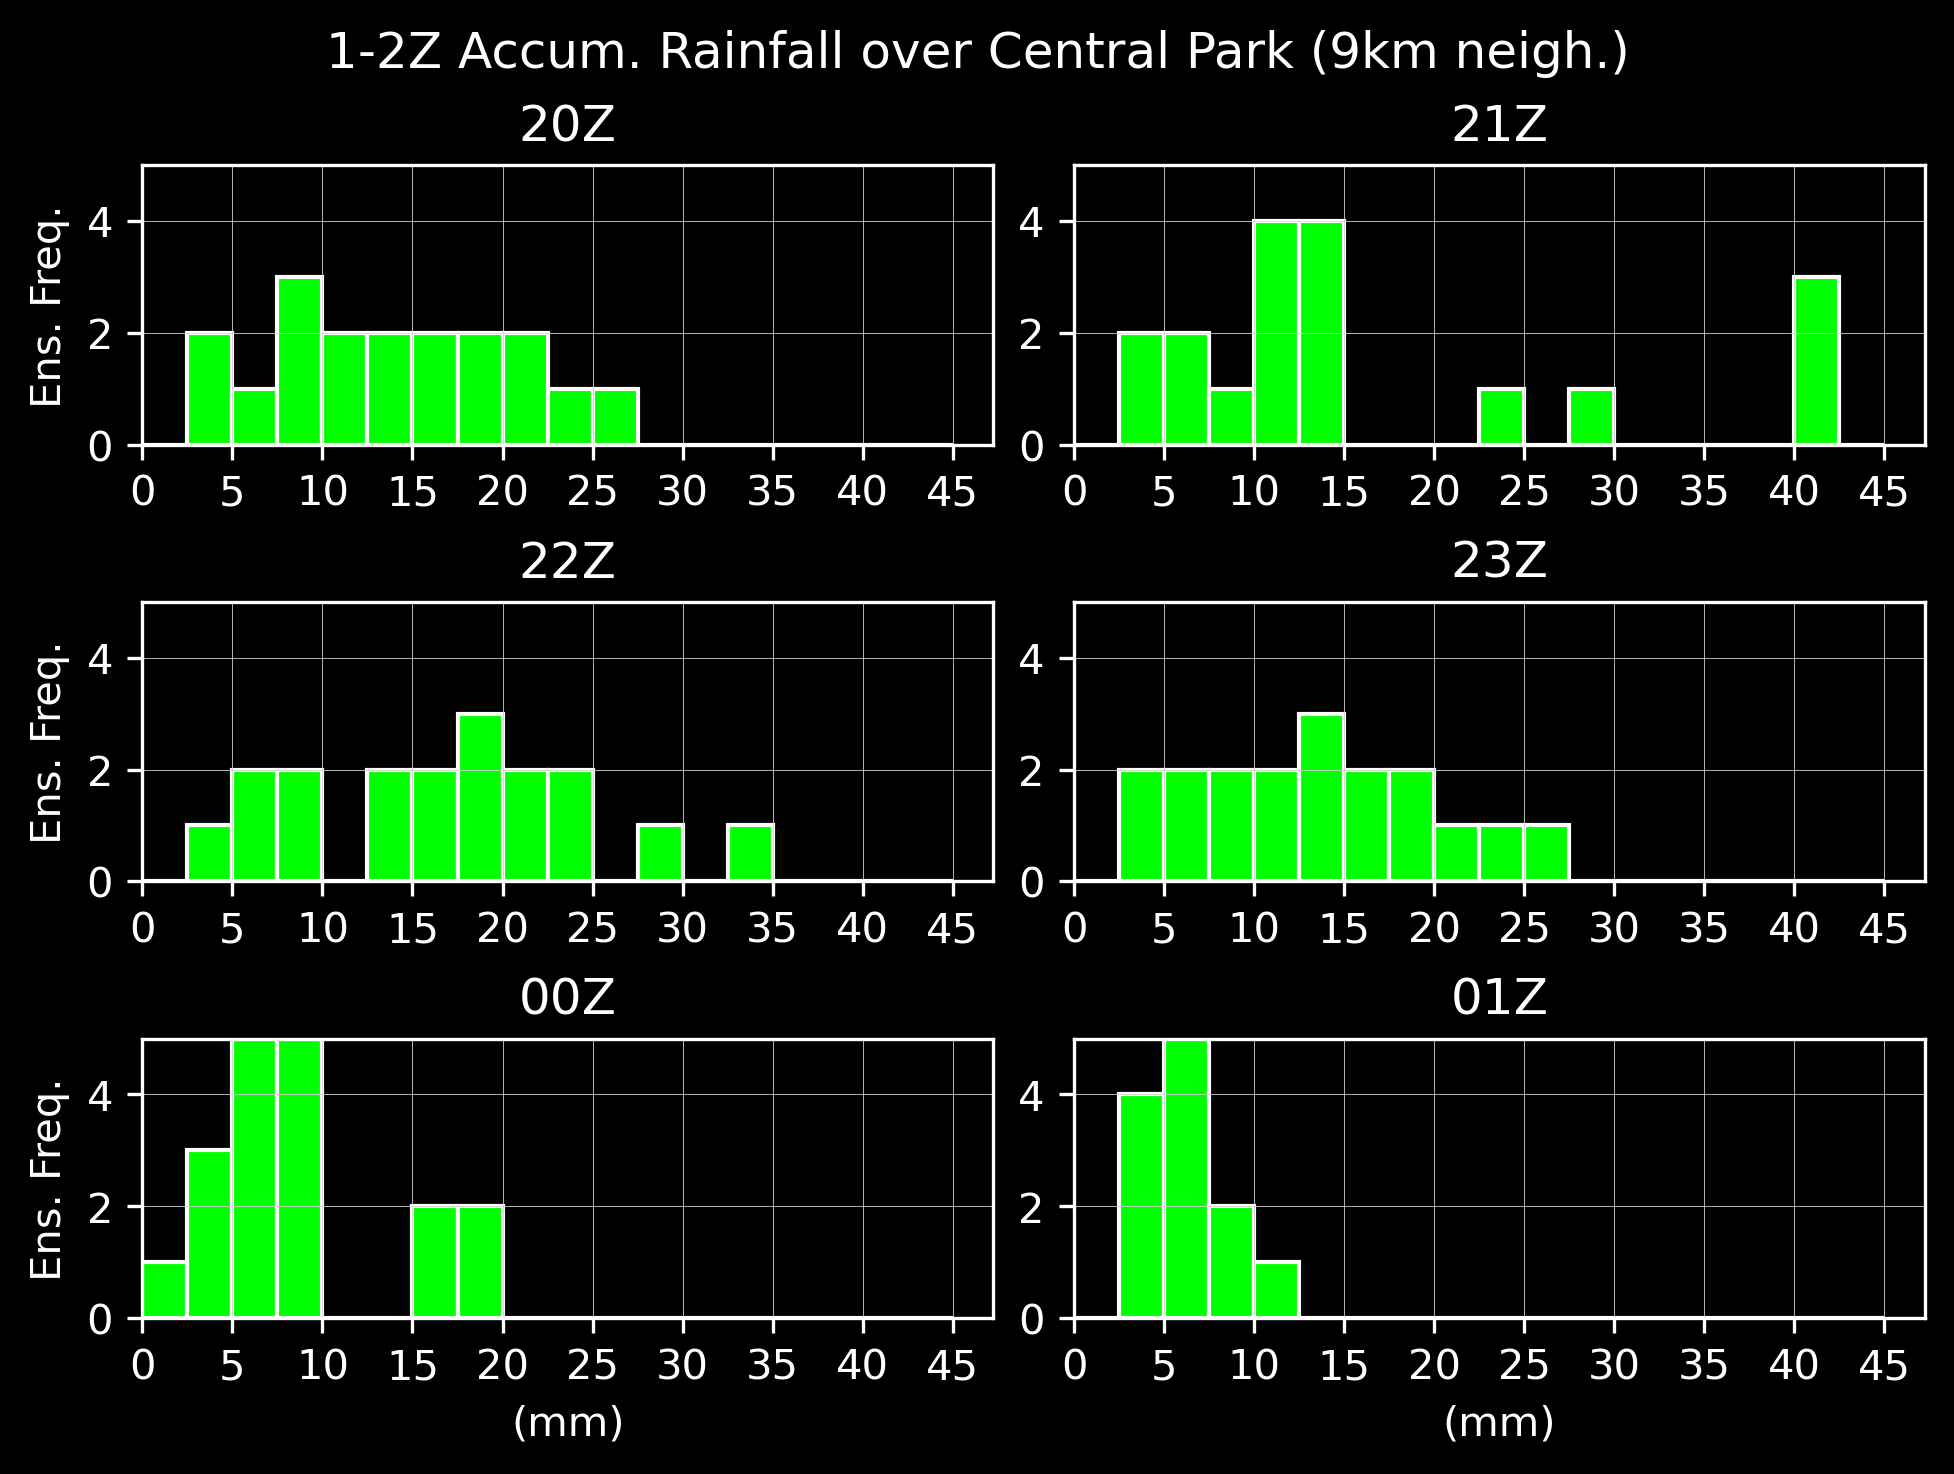

In [26]:
fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,
                        dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    xr.plot.hist(rainy_hours_3x3[i],ax=ax,edgecolor='white',bins=bin_edges,
                color="lime")
    ax.xaxis.set_tick_params(which='both',labelbottom=True)
    ax.set_xticks(np.arange(0,46,5))
    ax.yaxis.set_tick_params(which='both',labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_title(titles[i])
    ax.set_xlabel("")
    if(i%2==0):
        ax.set_ylabel("Ens. Freq.")

# axes.flatten()[-1].set_visible(False)
axes[2,1].set_xlabel("(mm)")
axes[2,0].set_xlabel("(mm)")

plt.ylim(0,5)
plt.xlim(0,)

plt.suptitle("1-2Z Accum. Rainfall over Central Park (9km neigh.)")
plt.show()

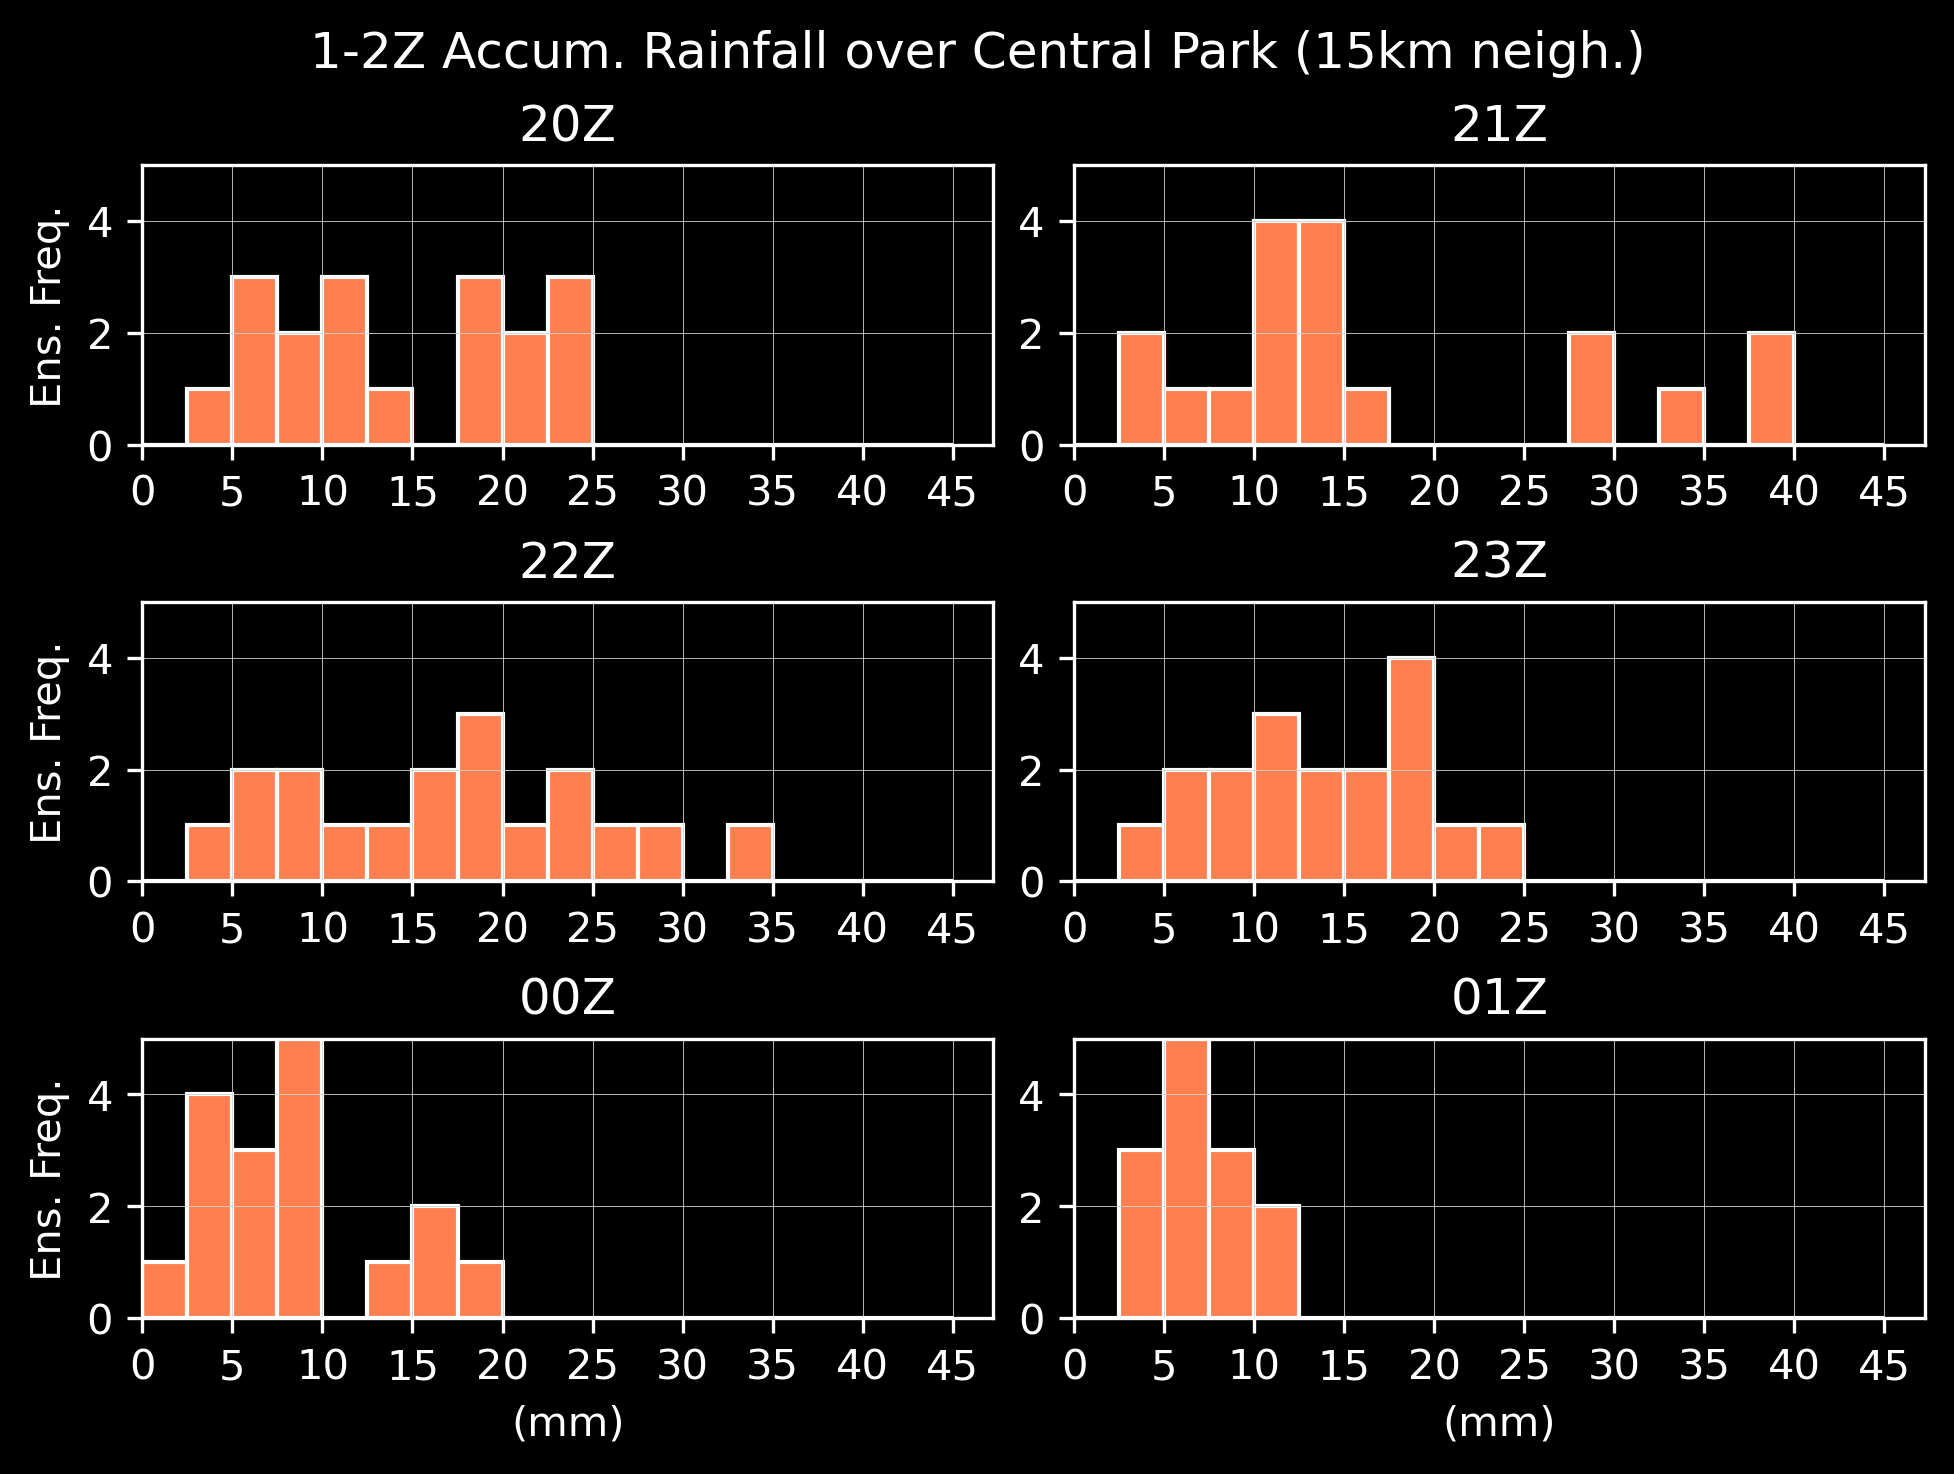

In [28]:
fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,
                        dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    xr.plot.hist(rainy_hours_5x5[i],ax=ax,edgecolor='white',bins=bin_edges,
                color="coral")
    ax.xaxis.set_tick_params(which='both',labelbottom=True)
    ax.set_xticks(np.arange(0,46,5))
    ax.yaxis.set_tick_params(which='both',labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_title(titles[i])
    ax.set_xlabel("")
    if(i%2==0):
        ax.set_ylabel("Ens. Freq.")

# axes.flatten()[-1].set_visible(False)
axes[2,1].set_xlabel("(mm)")
axes[2,0].set_xlabel("(mm)")

plt.ylim(0,5)
plt.xlim(0,)

plt.suptitle("1-2Z Accum. Rainfall over Central Park (15km neigh.)")
plt.show()

## Find maximum precip in box around Central Park

In [51]:
max_precip = [get_1Z_to_2Z(r).isel(south_north=slice(sn_ind-17,sn_ind+17),
                              west_east=slice(we_ind-17,we_ind+17)).max(
                                  dim=["south_north","west_east"]
                              ).load() for r in [rainnc_20Z,rainnc_21Z,rainnc_22Z,
                                          rainnc_23Z,rainnc_00Z,rainnc_01Z]]

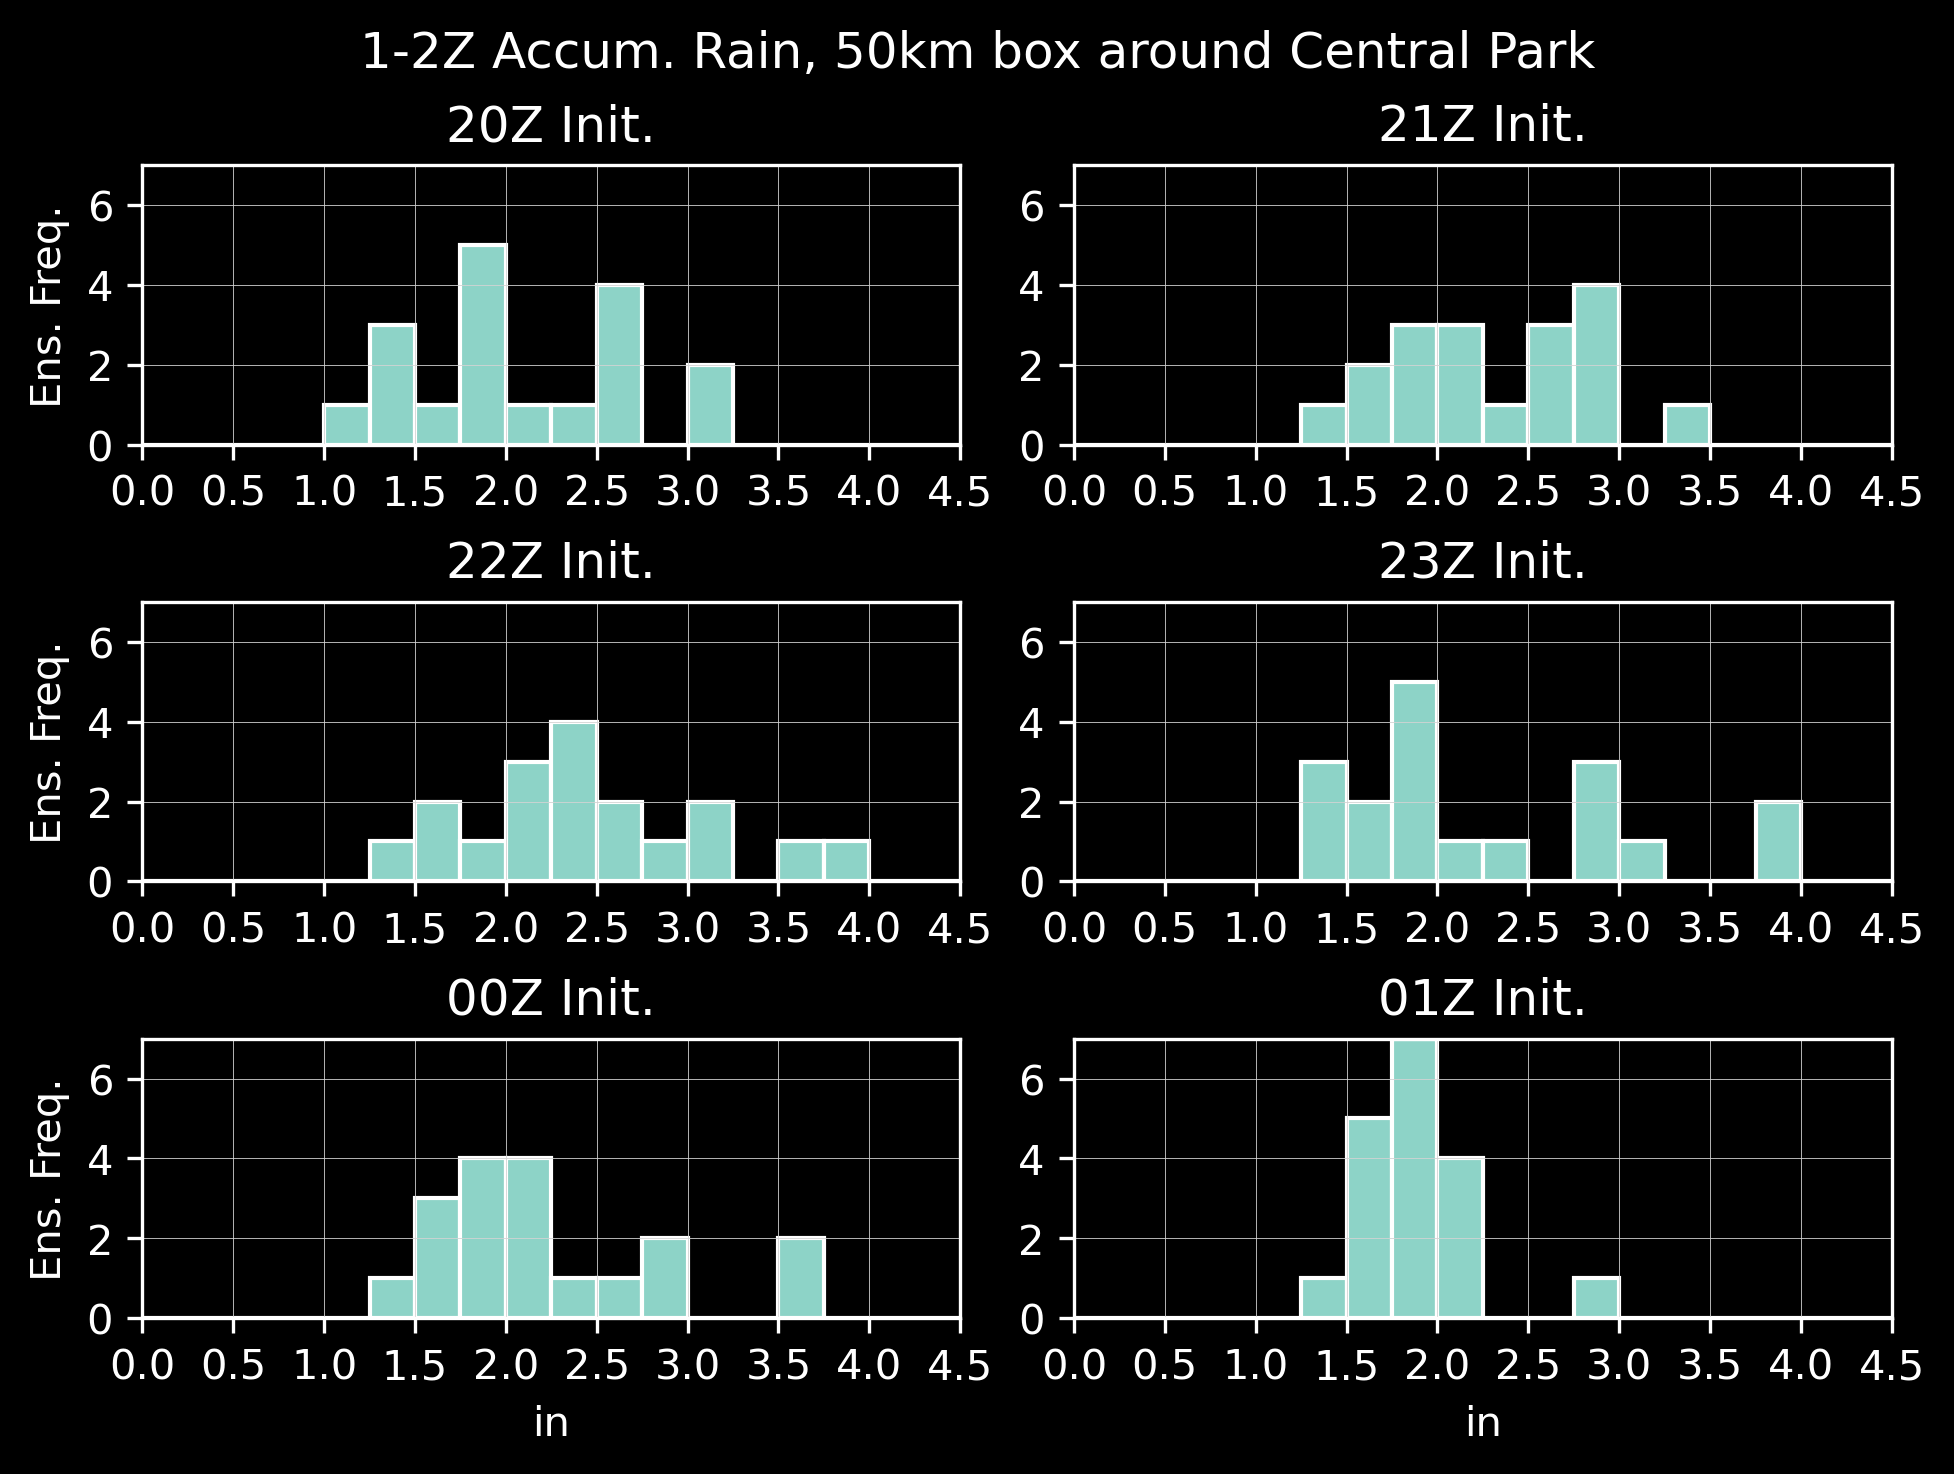

In [53]:
data_to_plot = max_precip
titles = ["20Z Init.","21Z Init.","22Z Init.","23Z Init.","00Z Init.","01Z Init."]
bin_edges = np.arange(0,4.56,0.25)

plt.style.use("dark_background")

fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,
                        dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    xr.plot.hist(data_to_plot[i].RAINNC/25.4,ax=ax,edgecolor='white',bins=bin_edges)
    ax.xaxis.set_tick_params(which='both',labelbottom=True)
    ax.set_xticks(np.arange(0,4.6,0.5))
    ax.set_yticks(np.arange(0,8,2))
    ax.yaxis.set_tick_params(which='both',labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_title(titles[i])
    ax.set_xlabel("")
    if(i%2==0):
        ax.set_ylabel("Ens. Freq.")
# xr.plot.hist(rainy_hour_20Z,ax=axes[0],edgecolor='white',bins=bin_edges)
# axes[0].xaxis.set_tick_params(which='both',labelbottom=True)

# xr.plot.hist(rainy_hour_22Z,ax=axes[1],edgecolor='white',bins=bin_edges)

# axes.flatten()[-1].set_visible(False)
axes[2,1].set_xlabel("in")
axes[2,0].set_xlabel("in")

plt.ylim(0,7)
plt.xlim(0,4.5)

plt.suptitle("1-2Z Accum. Rain, 50km box around Central Park")
plt.show()

In [55]:
max_precip = [get_1Z_to_2Z(r).isel(south_north=slice(sn_ind-34,sn_ind+34),
                              west_east=slice(we_ind-34,we_ind+34)).max(
                                  dim=["south_north","west_east"]
                              ).load() for r in [rainnc_20Z,rainnc_21Z,rainnc_22Z,
                                          rainnc_23Z,rainnc_00Z,rainnc_01Z]]

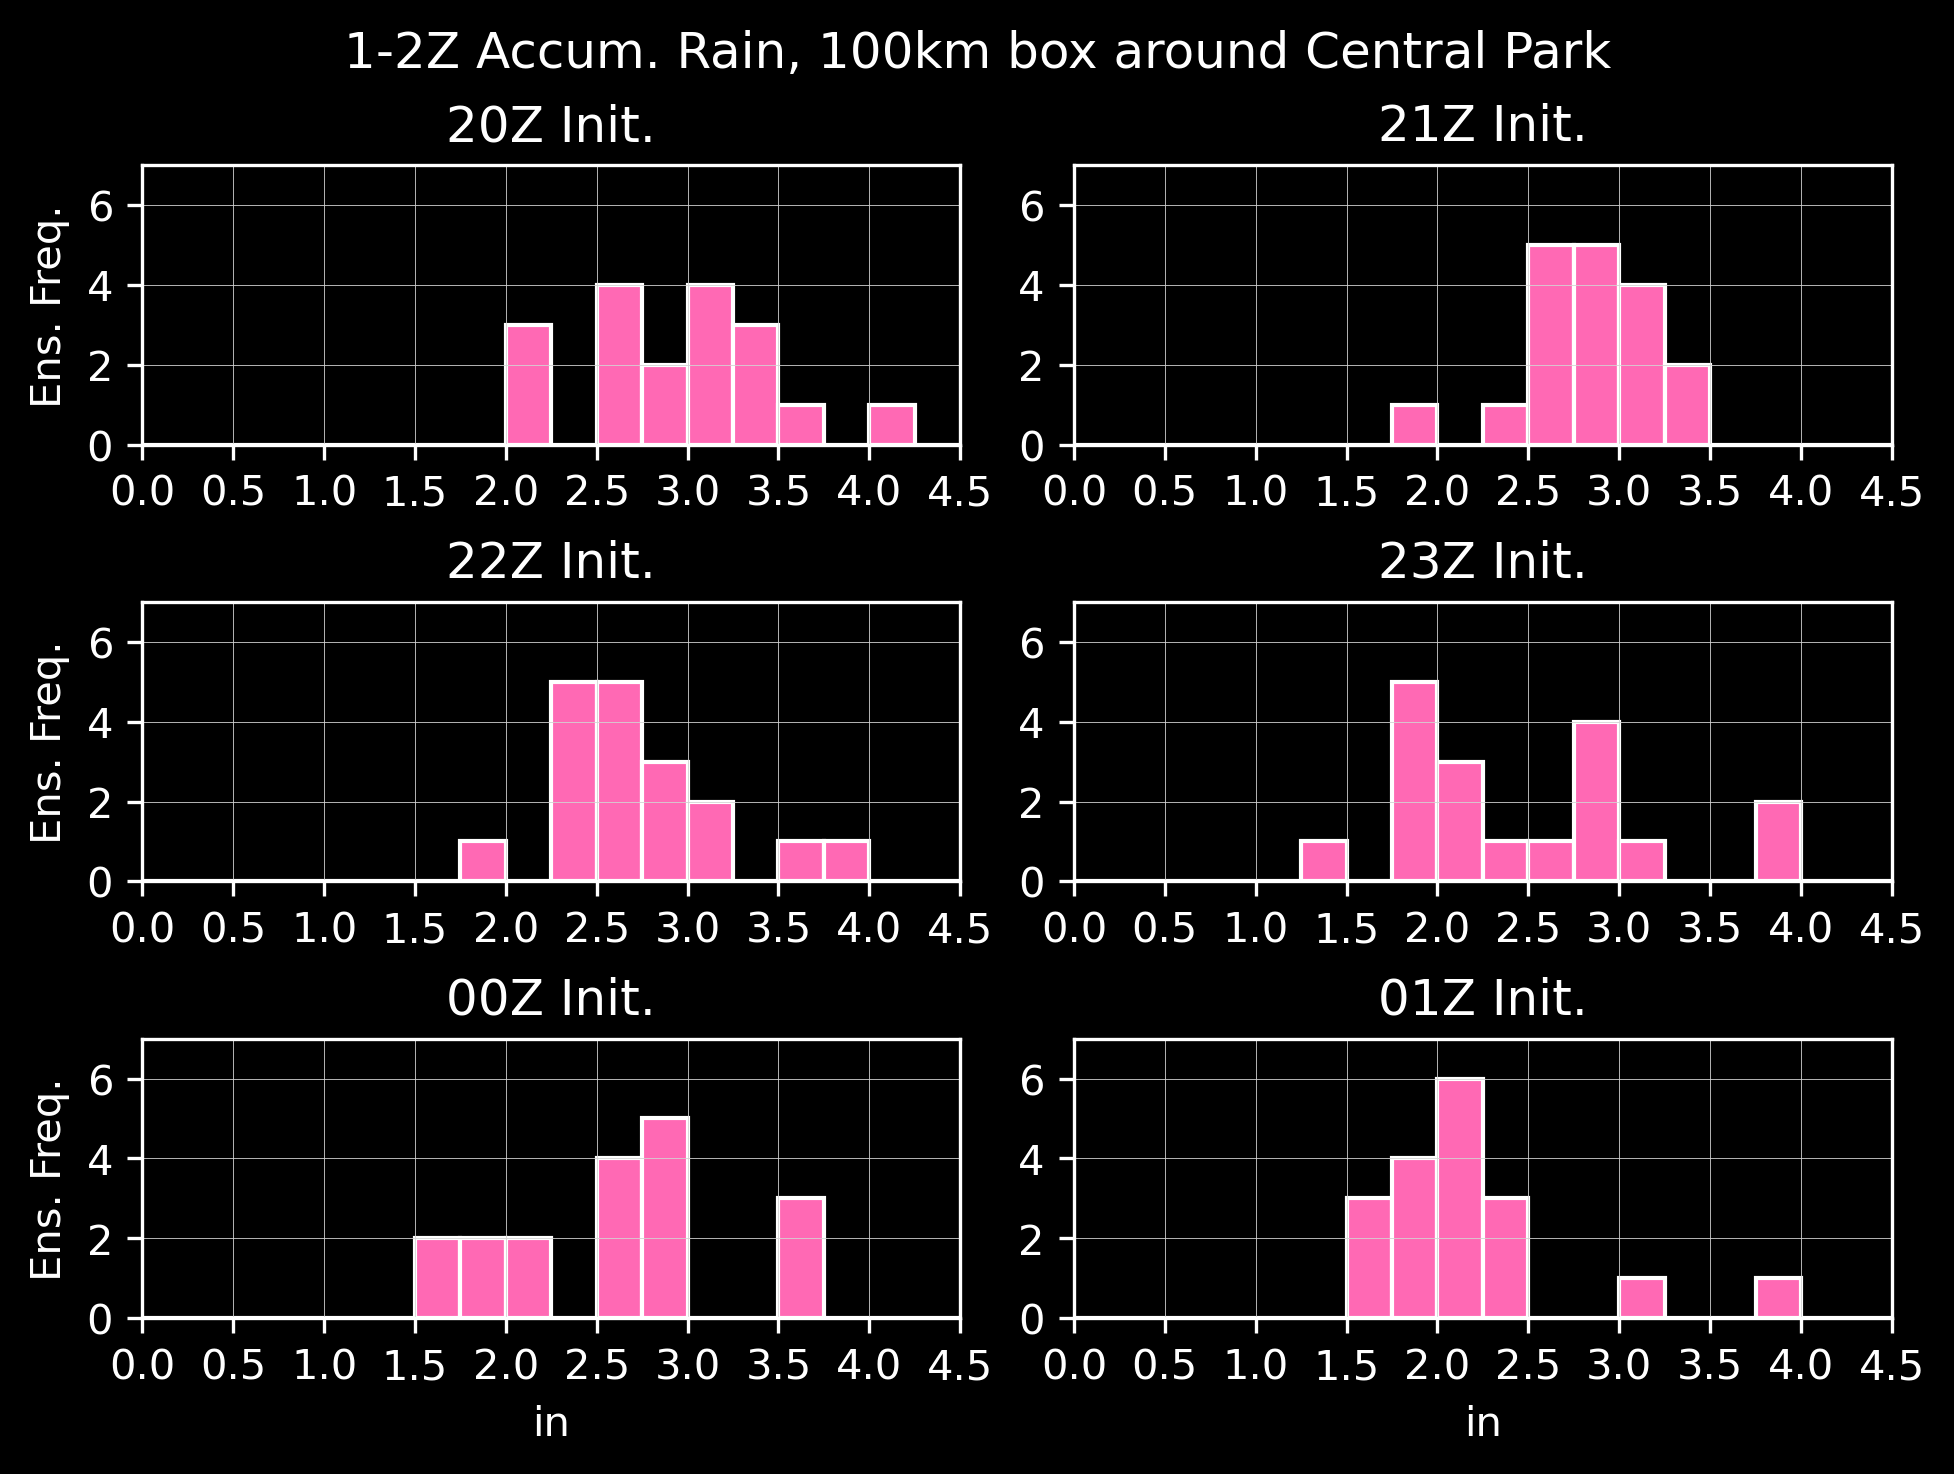

In [56]:
data_to_plot = max_precip
titles = ["20Z Init.","21Z Init.","22Z Init.","23Z Init.","00Z Init.","01Z Init."]
bin_edges = np.arange(0,4.56,0.25)

plt.style.use("dark_background")

fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,
                        dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    xr.plot.hist(data_to_plot[i].RAINNC/25.4,ax=ax,edgecolor='white',bins=bin_edges,
                 color="hotpink")
    ax.xaxis.set_tick_params(which='both',labelbottom=True)
    ax.set_xticks(np.arange(0,4.6,0.5))
    ax.set_yticks(np.arange(0,8,2))
    ax.yaxis.set_tick_params(which='both',labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_title(titles[i])
    ax.set_xlabel("")
    if(i%2==0):
        ax.set_ylabel("Ens. Freq.")
# xr.plot.hist(rainy_hour_20Z,ax=axes[0],edgecolor='white',bins=bin_edges)
# axes[0].xaxis.set_tick_params(which='both',labelbottom=True)

# xr.plot.hist(rainy_hour_22Z,ax=axes[1],edgecolor='white',bins=bin_edges)

# axes.flatten()[-1].set_visible(False)
axes[2,1].set_xlabel("in")
axes[2,0].set_xlabel("in")

plt.ylim(0,7)
plt.xlim(0,4.5)

plt.suptitle("1-2Z Accum. Rain, 100km box around Central Park")
plt.show()

## Density Map of Max Precip

In [5]:
# Put all the cumulative rain in a list
rainnc = [rainnc_20Z, rainnc_21Z, rainnc_22Z, rainnc_23Z, rainnc_00Z, rainnc_01Z]

# Calculate 5-minute rainfall accumulations (non-cumulative)
rainnc_5min = [r.diff(dim="Time",label="lower") for r in rainnc]

# Make it hourly
rainnc_hourly = [r.groupby(r.XTIME.dt.hour).sum() for r in rainnc_5min]

In [45]:
# Put all mslp in a list
mslp = [mslp_20Z, 
        mslp_21Z.rename({"MSLP":"mslp"}), 
        mslp_22Z.rename({"MSLP":"mslp"}), 
        mslp_23Z.rename({"MSLP":"mslp"}), 
        mslp_00Z.rename({"MSLP":"mslp"}), 
        mslp_01Z]

# Calculate hourly average MSLP
mslp_hourly = [m.groupby(m.XTIME.dt.hour).mean() for m in mslp]

# Smooth hourly mslp
mslp_hourly = [m.apply(gaussian_filter,sigma=1.5,axes=[2,3]) for m in mslp_hourly]
# mslp_hourly = [m.isel(west_east=slice(None,None,10),
#                       south_north=slice(None,None,10)) for m in mslp_hourly]
# mslp_lats=mslp[0].XLAT.isel(west_east=slice(None,None,10),
#                       south_north=slice(None,None,10),Time=0)
# mslp_lons=mslp[0].XLONG.isel(west_east=slice(None,None,10),
#                       south_north=slice(None,None,10),Time=0)

In [43]:
# Contruct data to plot

# Change this is you want to pick a different hour to plot
# None = plot all hours
hour = 1

lat = rainnc_20Z.XLAT.isel(Time=0)
lon = rainnc_20Z.XLONG.isel(Time=0)

# get central latitude and longitude for projections
central_latitude = 40.650017
central_longitude = -75.42999

# Get coordinates of max precip values
max_coords = [r.RAINNC.sel(hour=slice(hour,hour)).load().argmax(
    dim=["south_north","west_east"])
               for r in rainnc_hourly]
max_values = [np.array(r.RAINNC.sel(hour=slice(hour,hour)).load().max(
    dim=["south_north","west_east"])).ravel()/25.4
              for r in rainnc_hourly]

# Transform coordinates into lat/lon
max_lats = [np.array(lat.isel(west_east=m["west_east"],
                   south_north=m["south_north"])).ravel() 
                   for m in max_coords]
max_lons = [np.array(lon.isel(west_east=m["west_east"],
                   south_north=m["south_north"])).ravel() 
                   for m in max_coords]

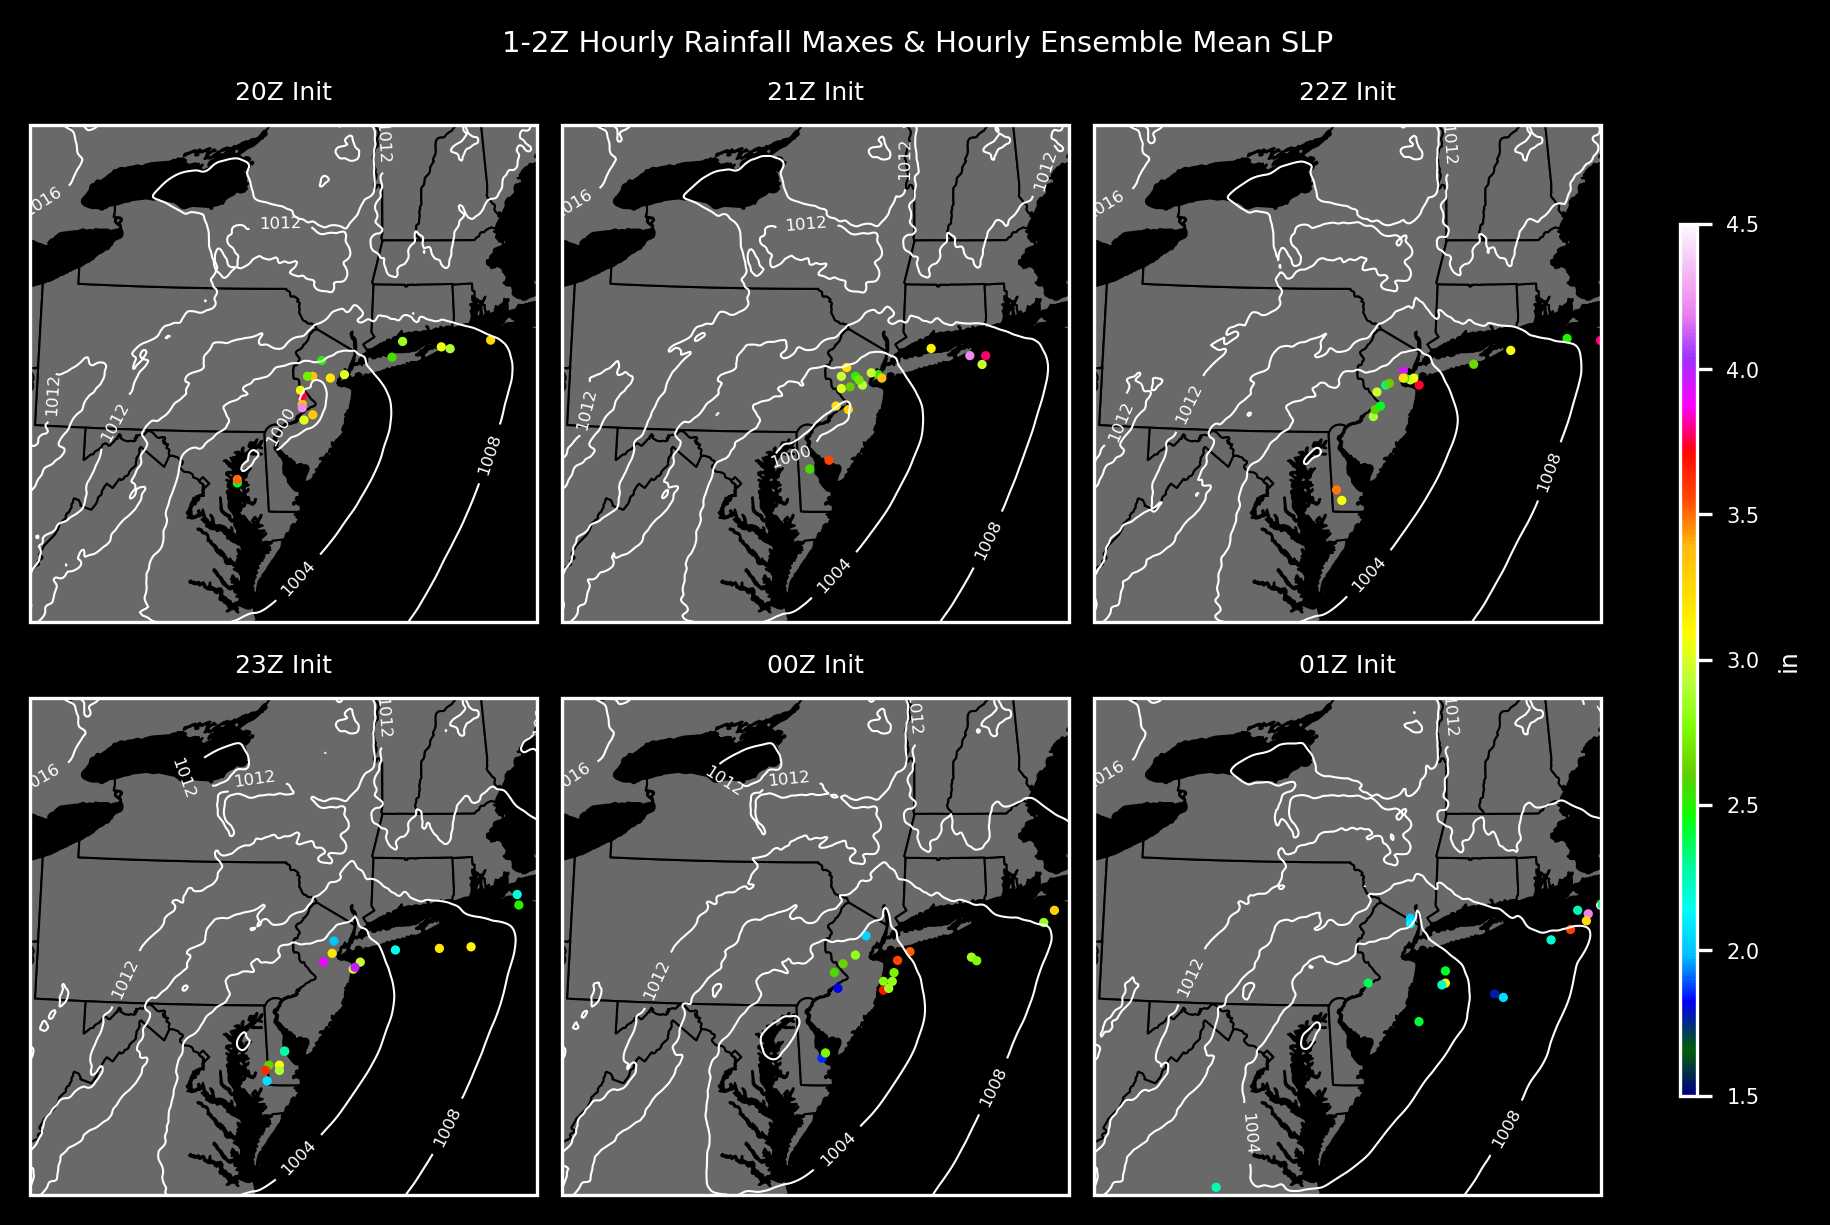

In [47]:
from matplotlib import colors


plt.style.use("dark_background")

linewidth=0.5
region=[-80.4,-70.4,36.6,44.5]
titles = ["20Z Init","21Z Init","22Z Init","23Z Init","00Z Init","01Z Init"]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,4))

for i,ax in enumerate(axes.flatten()):
    p = ax.scatter(max_lons[i],max_lats[i],transform=ccrs.PlateCarree(),
                                s=1.5,zorder=2,c=max_values[i],
                                vmin=1.5,vmax=4.5,cmap="gist_ncar")
    c = ax.contour(lon,lat,mslp_hourly[i].mslp.sel(hour=1).mean(dim="ens")/100,
                   colors="white",transform=ccrs.PlateCarree(),linewidths=0.5,
                   levels=np.arange(996,1025,4))
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth,facecolor="dimgray",
                        edgecolor="black")
    p.axes.set_extent(region,crs=ccrs.PlateCarree())
    ax.set_title(titles[i],fontsize=6)
    ax.clabel(c,c.levels,inline=True,fontsize=4)
plt.suptitle("1-2Z Hourly Rainfall Maxes & Hourly Ensemble Mean SLP",fontsize=7)
cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=50)
cbar.ax.tick_params(labelsize=5)
cbar.set_label("in",fontsize=6)
plt.show()

In [53]:
# Find a few ensemble members with very different precip maxima locations
# Let's try with 22Z

eastest = rainnc_hourly[2].RAINNC.isel(ens=max_lons[2].argmax()).sel(hour=1)
westest = rainnc_hourly[2].RAINNC.isel(ens=max_lons[2].argmin()).sel(hour=1)
# For a point in the center, calculate the median
med_idx = np.argsort(max_lons[2])[len(max_lons[2])//2]
centerest = rainnc_hourly[2].RAINNC.isel(ens=med_idx).sel(hour=1)

eastest_mslp = mslp_hourly[2].mslp.isel(ens=max_lons[2].argmax()).sel(hour=1)
westest_mslp = mslp_hourly[2].mslp.isel(ens=max_lons[2].argmin()).sel(hour=1)
centerest_mslp = mslp_hourly[2].mslp.isel(ens=med_idx).sel(hour=1)

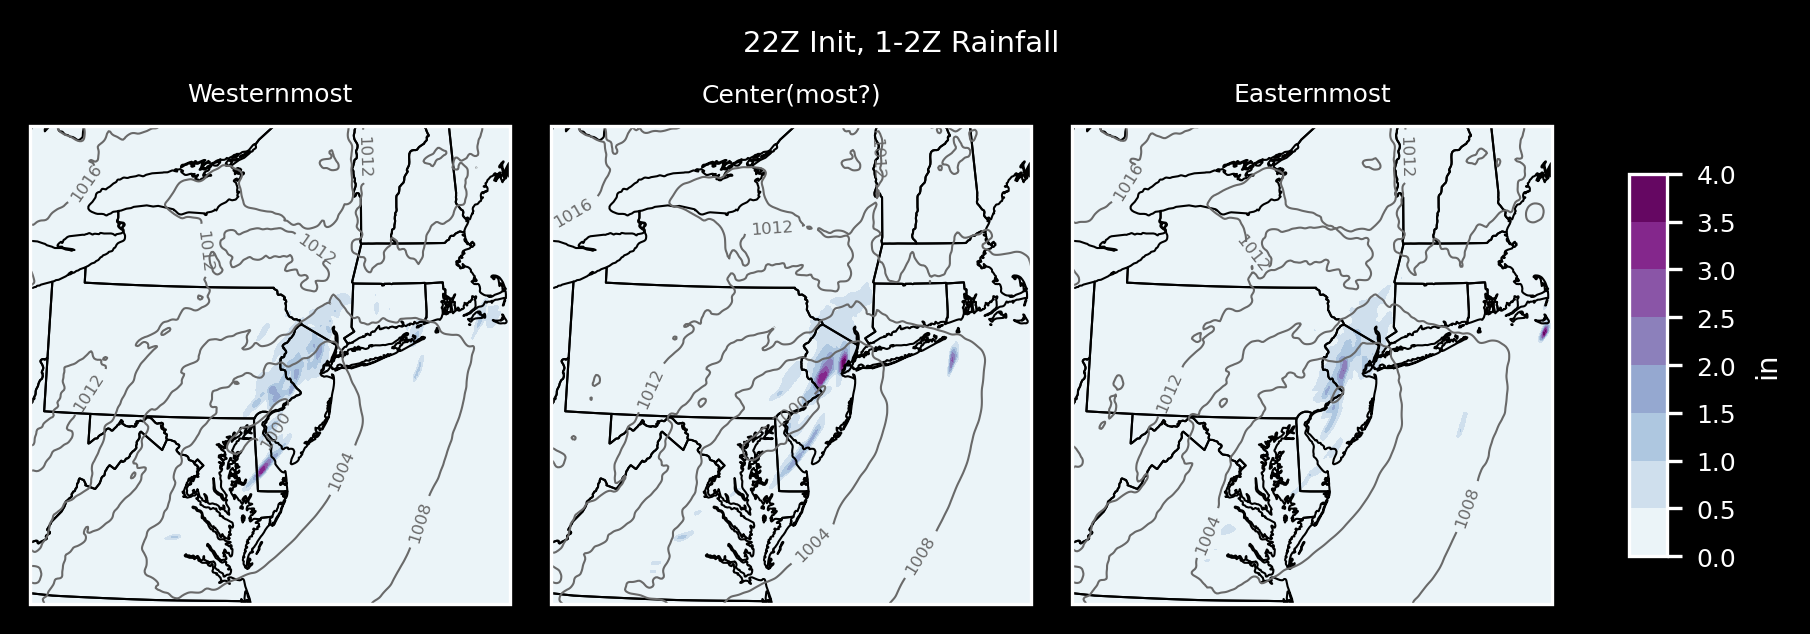

In [58]:
plt.style.use("dark_background")

linewidth=0.5
region=[-80.4,-70.4,36.6,44.5]
data_to_plot = [westest, centerest, eastest]
mslp_to_plot = [westest_mslp,centerest_mslp,eastest_mslp]
titles = ["Westernmost","Center(most?)","Easternmost"]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude,
                             standard_parallels=(30,60))

fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,2))

for i,ax in enumerate(axes):
    p = ax.contourf(lon,lat,data_to_plot[i]/25.4,
                      transform=ccrs.PlateCarree(),
                      cmap="BuPu",levels=np.arange(0,4.1,0.5))
    c = ax.contour(lon,lat,mslp_to_plot[i]/100,
                   colors="dimgray",transform=ccrs.PlateCarree(),linewidths=0.5,
                   levels=np.arange(996,1025,4))
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.clabel(c,c.levels,inline=True,fontsize=4)
    ax.set_title(titles[i],fontsize=6)

plt.suptitle("22Z Init, 1-2Z Rainfall",fontsize=7)
cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=10)
cbar.ax.tick_params(labelsize=6)
cbar.set_label("in",fontsize=7)
plt.show()

In [59]:
# Repeat for 00Z

eastest = rainnc_hourly[4].RAINNC.isel(ens=max_lons[4].argmax()).sel(hour=1)
westest = rainnc_hourly[4].RAINNC.isel(ens=max_lons[4].argmin()).sel(hour=1)
# For a point in the center, calculate the median
med_idx = np.argsort(max_lons[4])[len(max_lons[4])//2]
centerest = rainnc_hourly[4].RAINNC.isel(ens=med_idx).sel(hour=1) 

eastest_mslp = mslp_hourly[4].mslp.isel(ens=max_lons[2].argmax()).sel(hour=1)
westest_mslp = mslp_hourly[4].mslp.isel(ens=max_lons[2].argmin()).sel(hour=1)
centerest_mslp = mslp_hourly[4].mslp.isel(ens=med_idx).sel(hour=1)

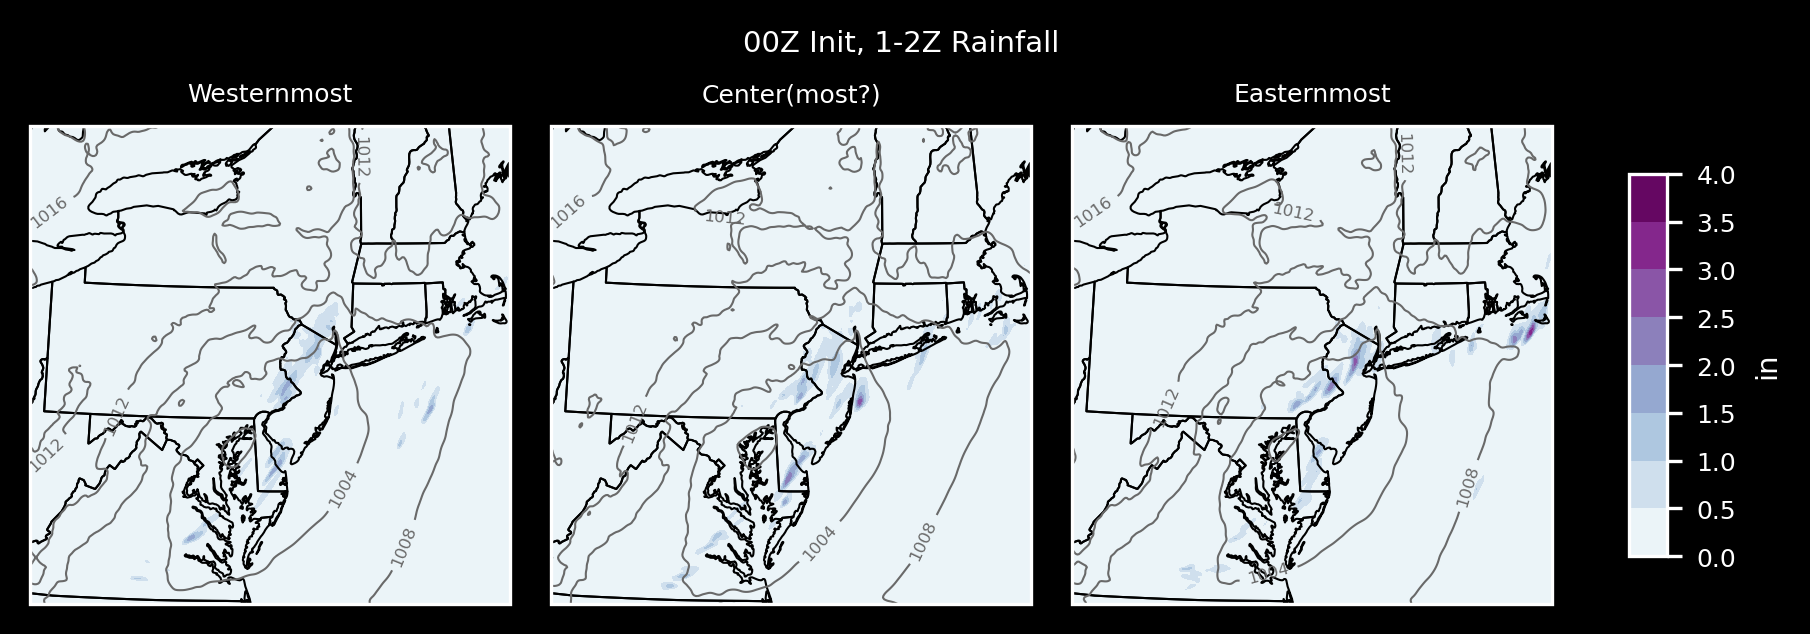

In [60]:
plt.style.use("dark_background")

linewidth=0.5
region=[-80.4,-70.4,36.6,44.5]
data_to_plot = [westest, centerest, eastest]
mslp_to_plot = [westest_mslp,centerest_mslp,eastest_mslp]
titles = ["Westernmost","Center(most?)","Easternmost"]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude,
                             standard_parallels=(30,60))

fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,2))

for i,ax in enumerate(axes):
    p = ax.contourf(lon,lat,data_to_plot[i]/25.4,
                      transform=ccrs.PlateCarree(),
                      cmap="BuPu",levels=np.arange(0,4.1,0.5))
    c = ax.contour(lon,lat,mslp_to_plot[i]/100,
                   colors="dimgray",transform=ccrs.PlateCarree(),linewidths=0.5,
                   levels=np.arange(996,1025,4))
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.clabel(c,c.levels,inline=True,fontsize=4)
    ax.set_title(titles[i],fontsize=6)

plt.suptitle("00Z Init, 1-2Z Rainfall",fontsize=7)
cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=10)
cbar.ax.tick_params(labelsize=6)
cbar.set_label("in",fontsize=7)
plt.show()

## Area-averaged histogram & member comparison

In [5]:
# Put all the cumulative rain in a list
rainnc = [rainnc_20Z, rainnc_21Z, rainnc_22Z, rainnc_23Z, rainnc_00Z, rainnc_01Z]

# Calculate 5-minute rainfall accumulations (non-cumulative)
rainnc_5min = [r.diff(dim="Time",label="lower") for r in rainnc]

# Make it hourly
rainnc_hourly = [r.groupby(r.XTIME.dt.hour).sum() for r in rainnc_5min]

In [6]:
# Calculate the area-averaged precip for 1-2Z
# +- 17 indices = 50km box around central park
area_avg = [r.RAINNC.sel(hour=1).isel(
    south_north=slice(sn_ind-17,sn_ind+17),
    west_east=slice(we_ind-17,we_ind+17)
).mean(dim=["south_north","west_east"]) for r in rainnc_hourly]

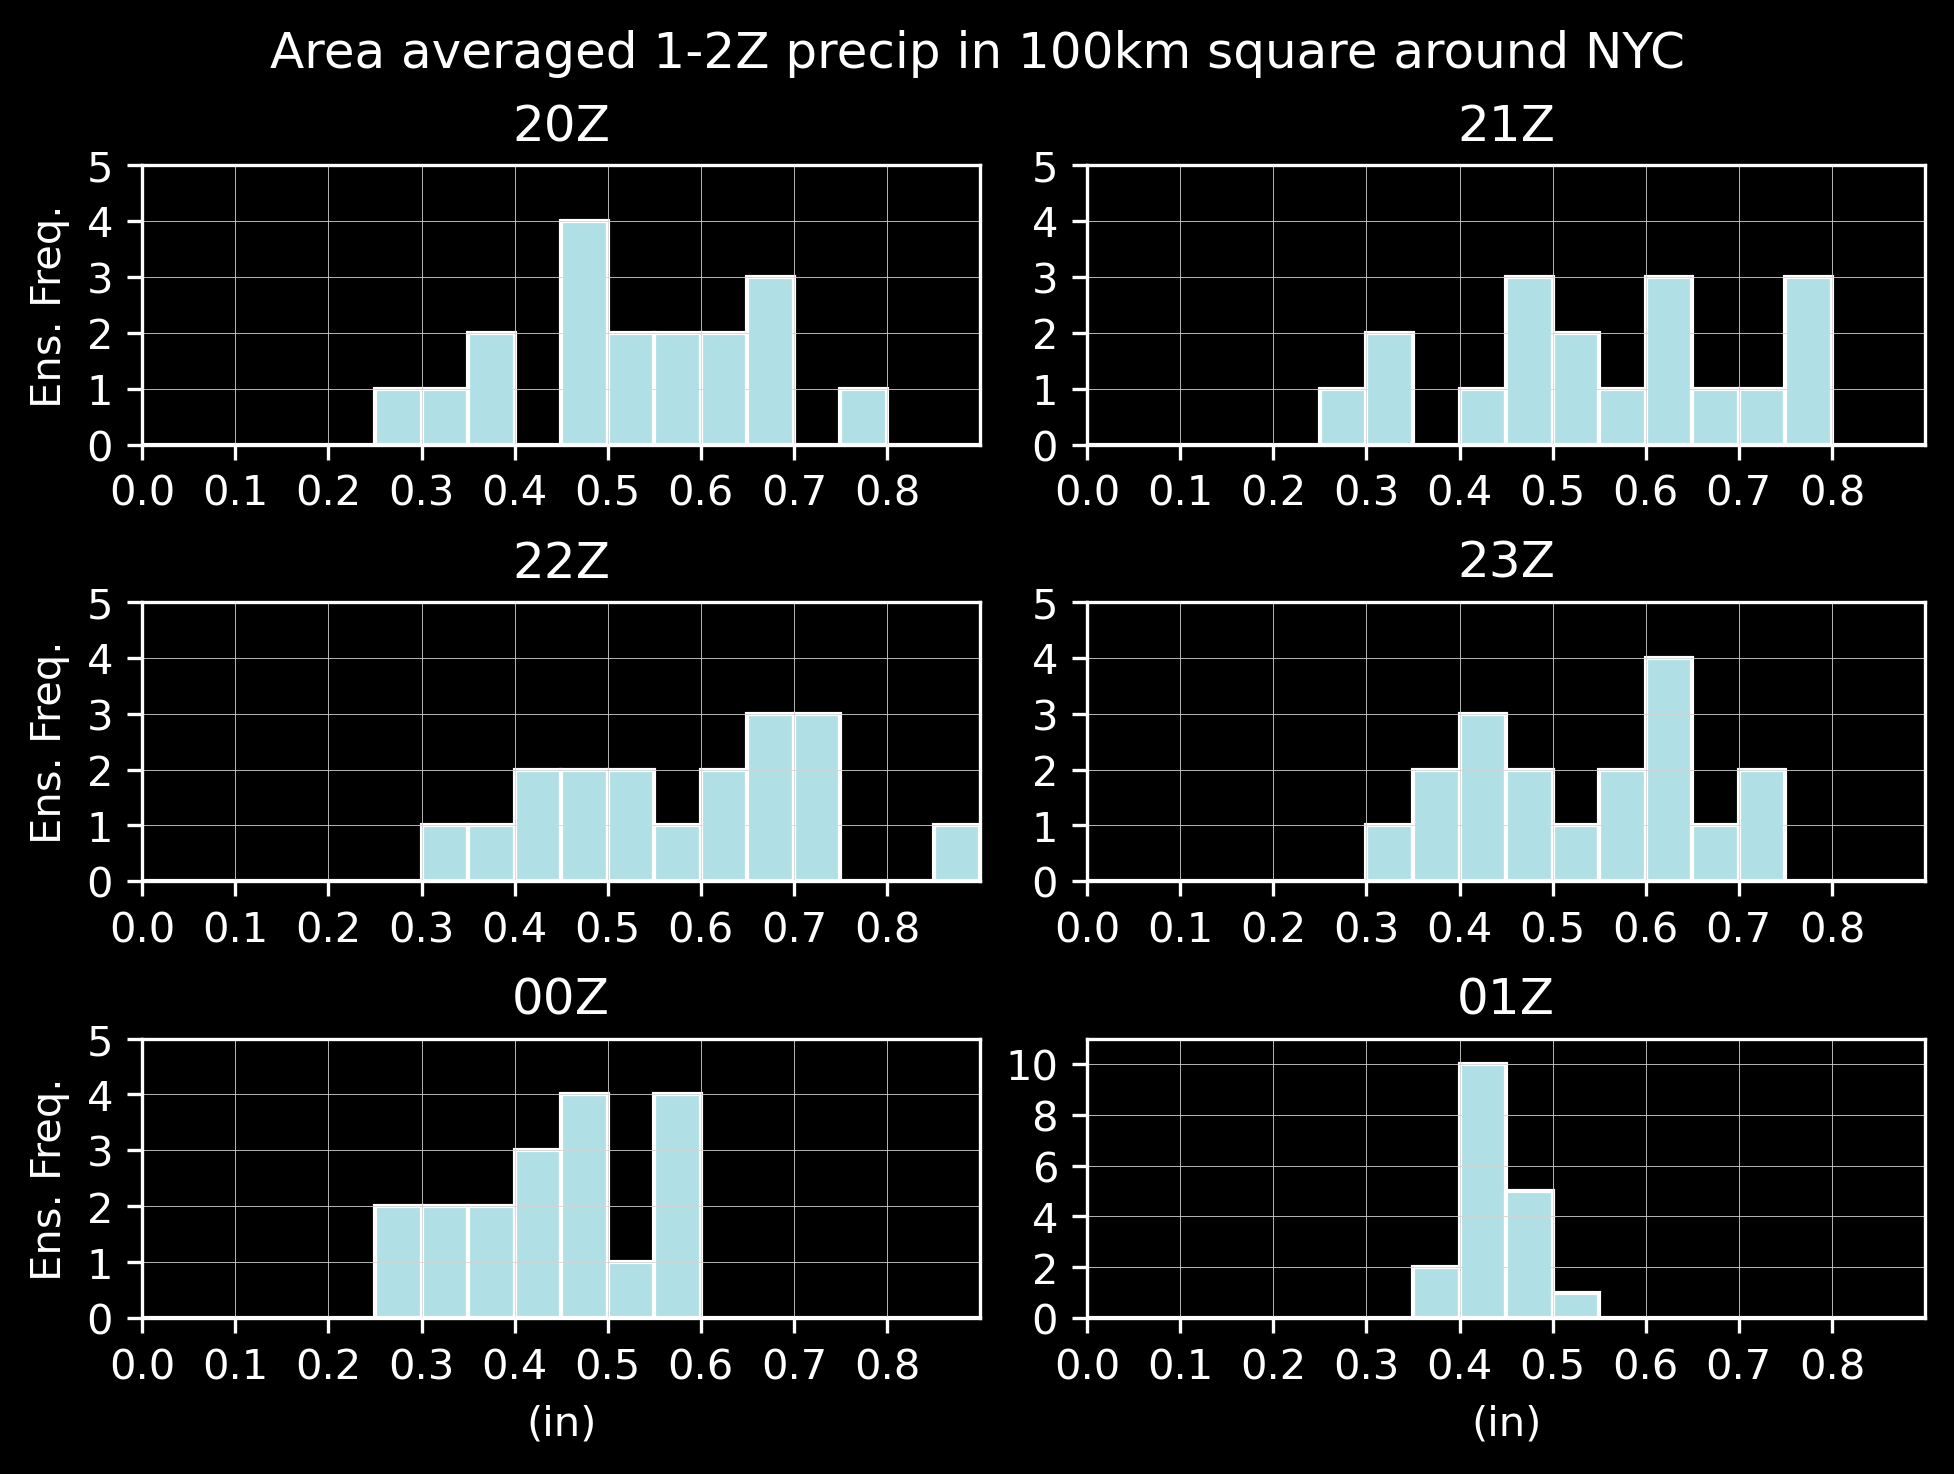

In [9]:
titles = ["20Z","21Z","22Z","23Z","00Z","01Z"]
bin_edges = np.arange(0,.91,.05)

plt.style.use("dark_background")

fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,#sharey=True,
                        dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    xr.plot.hist(area_avg[i]/25.4,ax=ax,edgecolor='white',bins=bin_edges,
                color="powderblue")
    ax.xaxis.set_tick_params(which='both',labelbottom=True)
    ax.set_xticks(np.arange(0,0.86,.1))
    ax.yaxis.set_tick_params(which='both',labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_title(titles[i])
    ax.set_xlabel("")
    if(i%2==0):
        ax.set_ylabel("Ens. Freq.")
    if(i!=5):
        ax.set_yticks(np.arange(0,6,1))
        ax.set_ylim(0,5)
    else:
        ax.set_yticks(np.arange(0,11,2))
        ax.set_ylim(0,11)


# axes.flatten()[-1].set_visible(False)
axes[2,1].set_xlabel("(in)")
axes[2,0].set_xlabel("(in)")

plt.xlim(0,0.9)

plt.suptitle("Area averaged 1-2Z precip in 100km square around NYC")
plt.show()

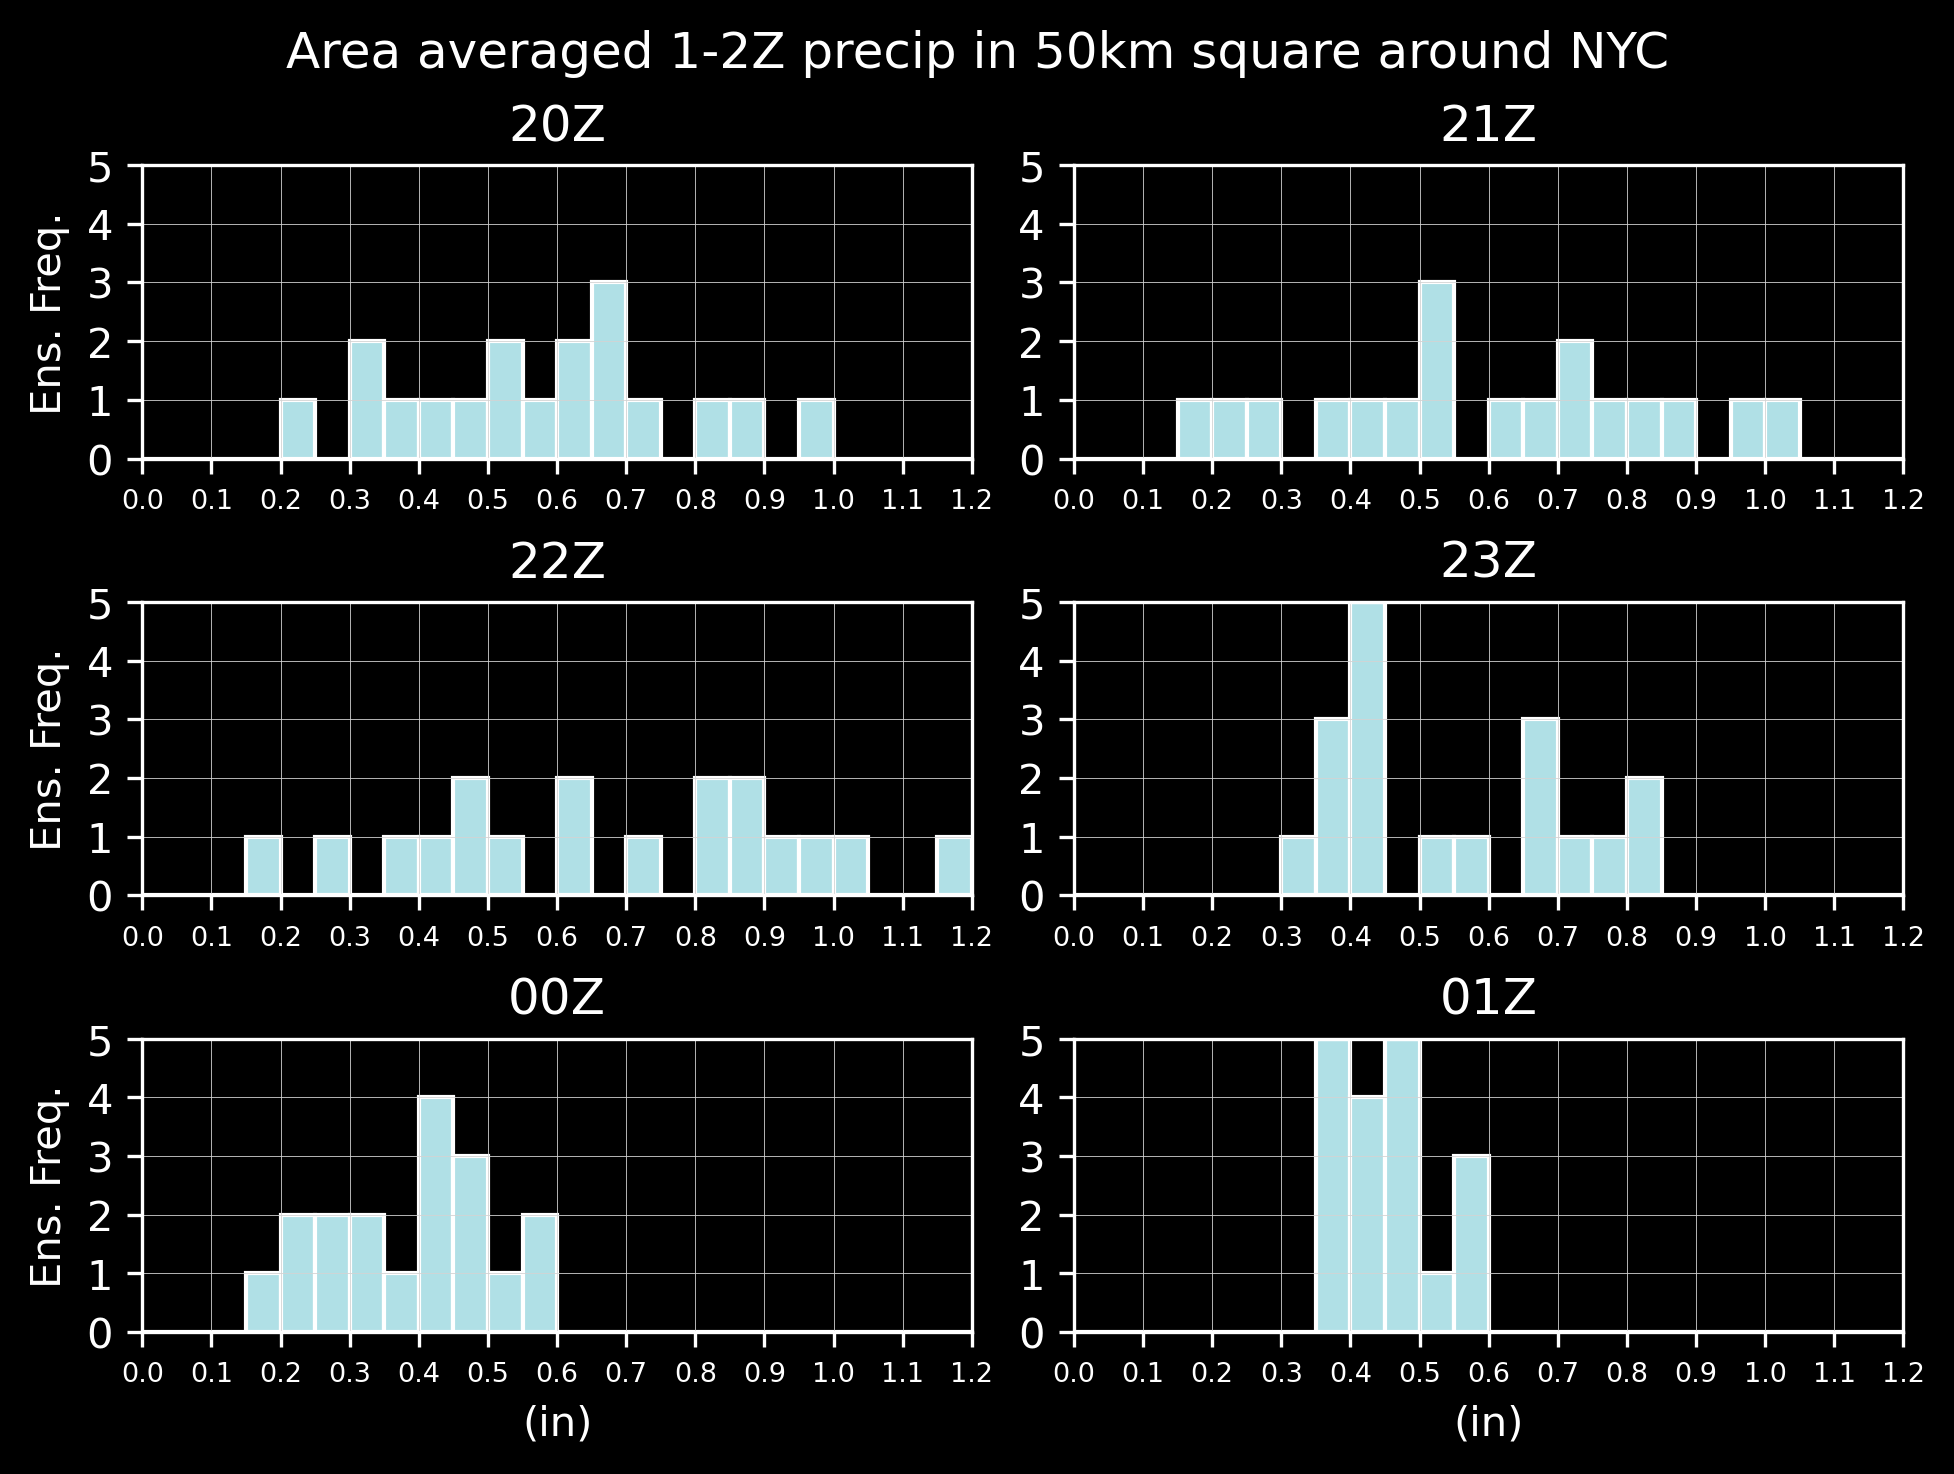

In [10]:
# Repeat but for a smaller box
# Calculate the area-averaged precip for 1-2Z
# +- 9 indices = 25 km box around central park
area_avg = [r.RAINNC.sel(hour=1).isel(
    south_north=slice(sn_ind-9,sn_ind+9),
    west_east=slice(we_ind-9,we_ind+9)
).mean(dim=["south_north","west_east"]) for r in rainnc_hourly]
titles = ["20Z","21Z","22Z","23Z","00Z","01Z"]
bin_edges = np.arange(0,1.21,.05)

plt.style.use("dark_background")

fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,#sharey=True,
                        dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    xr.plot.hist(area_avg[i]/25.4,ax=ax,edgecolor='white',bins=bin_edges,
                color="powderblue")
    ax.xaxis.set_tick_params(which='both',labelbottom=True,labelsize=6.5)
    ax.set_xticks(np.arange(0,1.21,.1))
    ax.yaxis.set_tick_params(which='both',labelleft=True)
    ax.grid(color='lightgray',linewidth=0.2)
    ax.set_title(titles[i])
    ax.set_xlabel("")
    if(i%2==0):
        ax.set_ylabel("Ens. Freq.")
    ax.set_yticks(np.arange(0,6,1))
    ax.set_ylim(0,5)


# axes.flatten()[-1].set_visible(False)
axes[2,1].set_xlabel("(in)")
axes[2,0].set_xlabel("(in)")

plt.xlim(0,1.2)

plt.suptitle("Area averaged 1-2Z precip in 50km square around NYC")
plt.show()

In [13]:
# We have to load area_avg because dask doesn't support argsort yet
area_avg = [a.load() for a in area_avg]

# 22Z has the biggest spread, so let's look at that
wet1 = rainnc_hourly[2].RAINNC.isel(ens=int(area_avg[2].argmax()))
wet2 = rainnc_hourly[2].RAINNC.isel(ens=int(area_avg[2].argsort()[-2]))
dry1 = rainnc_hourly[2].RAINNC.isel(ens=int(area_avg[2].argmin()))
dry2 = rainnc_hourly[2].RAINNC.isel(ens=int(area_avg[2].argsort()[1]))
center1= rainnc_hourly[2].RAINNC.isel(
    ens=int(area_avg[2].argsort()[len(area_avg[2])//2]))
center2= rainnc_hourly[2].RAINNC.isel(
    ens=int(area_avg[2].argsort()[(len(area_avg[2])//2)-1]))

In [49]:
import matplotlib.colors as colors
bounds=[0,0.01,0.1,0.25,1,1.5,2,2.5,3,4,5]
norm=colors.BoundaryNorm(boundaries=bounds,ncolors=256)

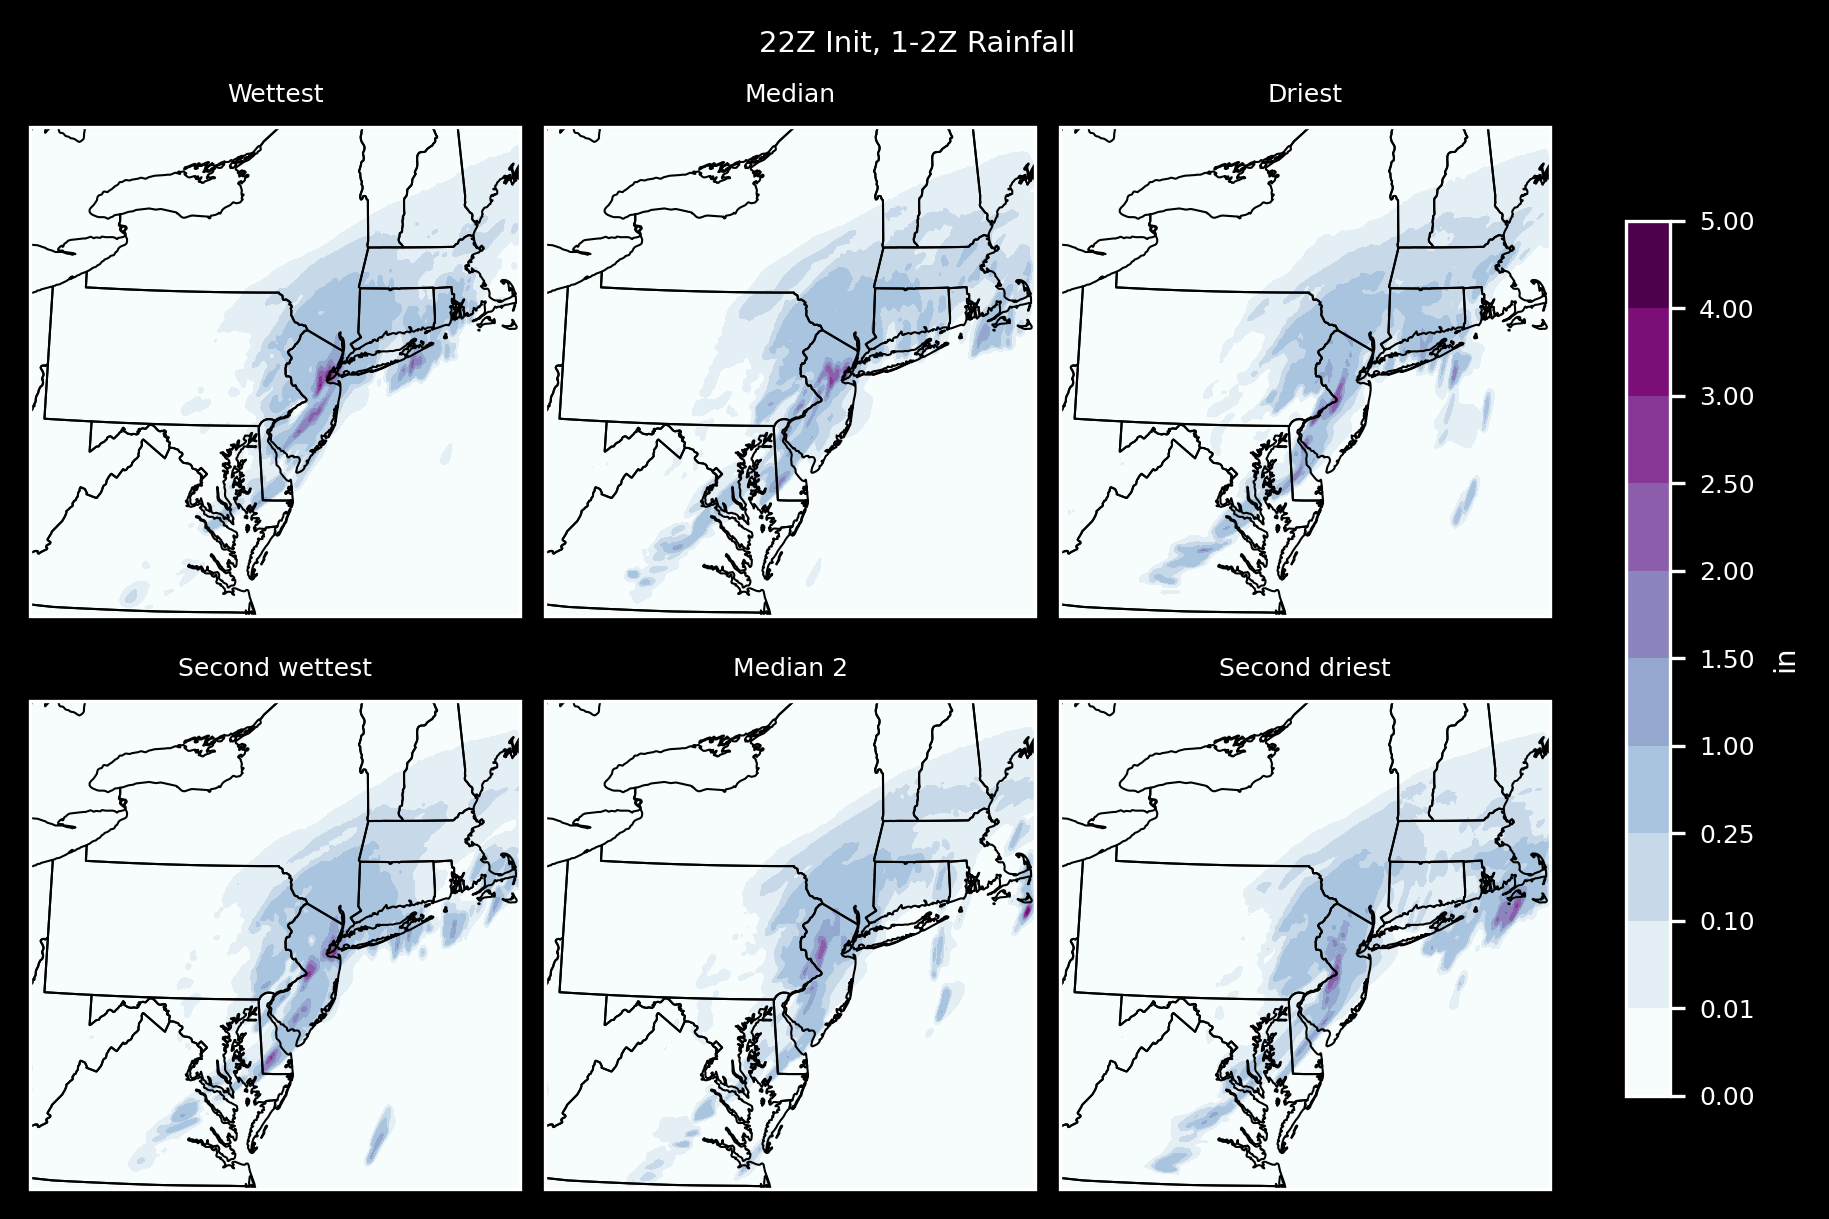

In [54]:
plt.style.use("dark_background")

linewidth=0.5
# region=[-80.4,-70.4,36.6,44.5]
data_to_plot = [wet1, center1, dry1,
                wet2, center2, dry2]
titles = ["Wettest","Median","Driest",
          "Second wettest","Median 2","Second driest"]
lat=rainnc_20Z.XLAT.isel(Time=0)
lon=rainnc_20Z.XLONG.isel(Time=0)

proj = ccrs.LambertConformal(central_longitude=rainnc_20Z.attrs['CEN_LON'],
                             central_latitude=rainnc_20Z.attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,4))

for i,ax in enumerate(axes.flatten()):
    # p = ax.contourf(lon,lat,data_to_plot[i].sel(hour=1)/25.4,
    #                   transform=ccrs.PlateCarree(),
    #                   cmap="BuPu",levels=np.arange(0,4.6,0.5))
    p = ax.contourf(lon,lat,data_to_plot[i].sel(hour=1)/25.4,
                      transform=ccrs.PlateCarree(),
                      cmap="BuPu",norm=norm,levels=bounds)
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i],fontsize=6)

plt.suptitle("22Z Init, 1-2Z Rainfall",fontsize=7)
cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=20)
cbar.ax.tick_params(labelsize=6)
cbar.set_label("in",fontsize=7)
cbar.set_ticks(bounds)
plt.show()

In [16]:
# Make a paintball plot
gt1 = [r.RAINNC.sel(hour=1)/25.4 >= 1 for r in rainnc_hourly]
gt2 = [r.RAINNC.sel(hour=1)/25.4 >= 2 for r in rainnc_hourly]
gt3 = [r.RAINNC.sel(hour=1)/25.4 >= 3 for r in rainnc_hourly]
colors = plt.get_cmap('hsv')(np.linspace(0,1,18))

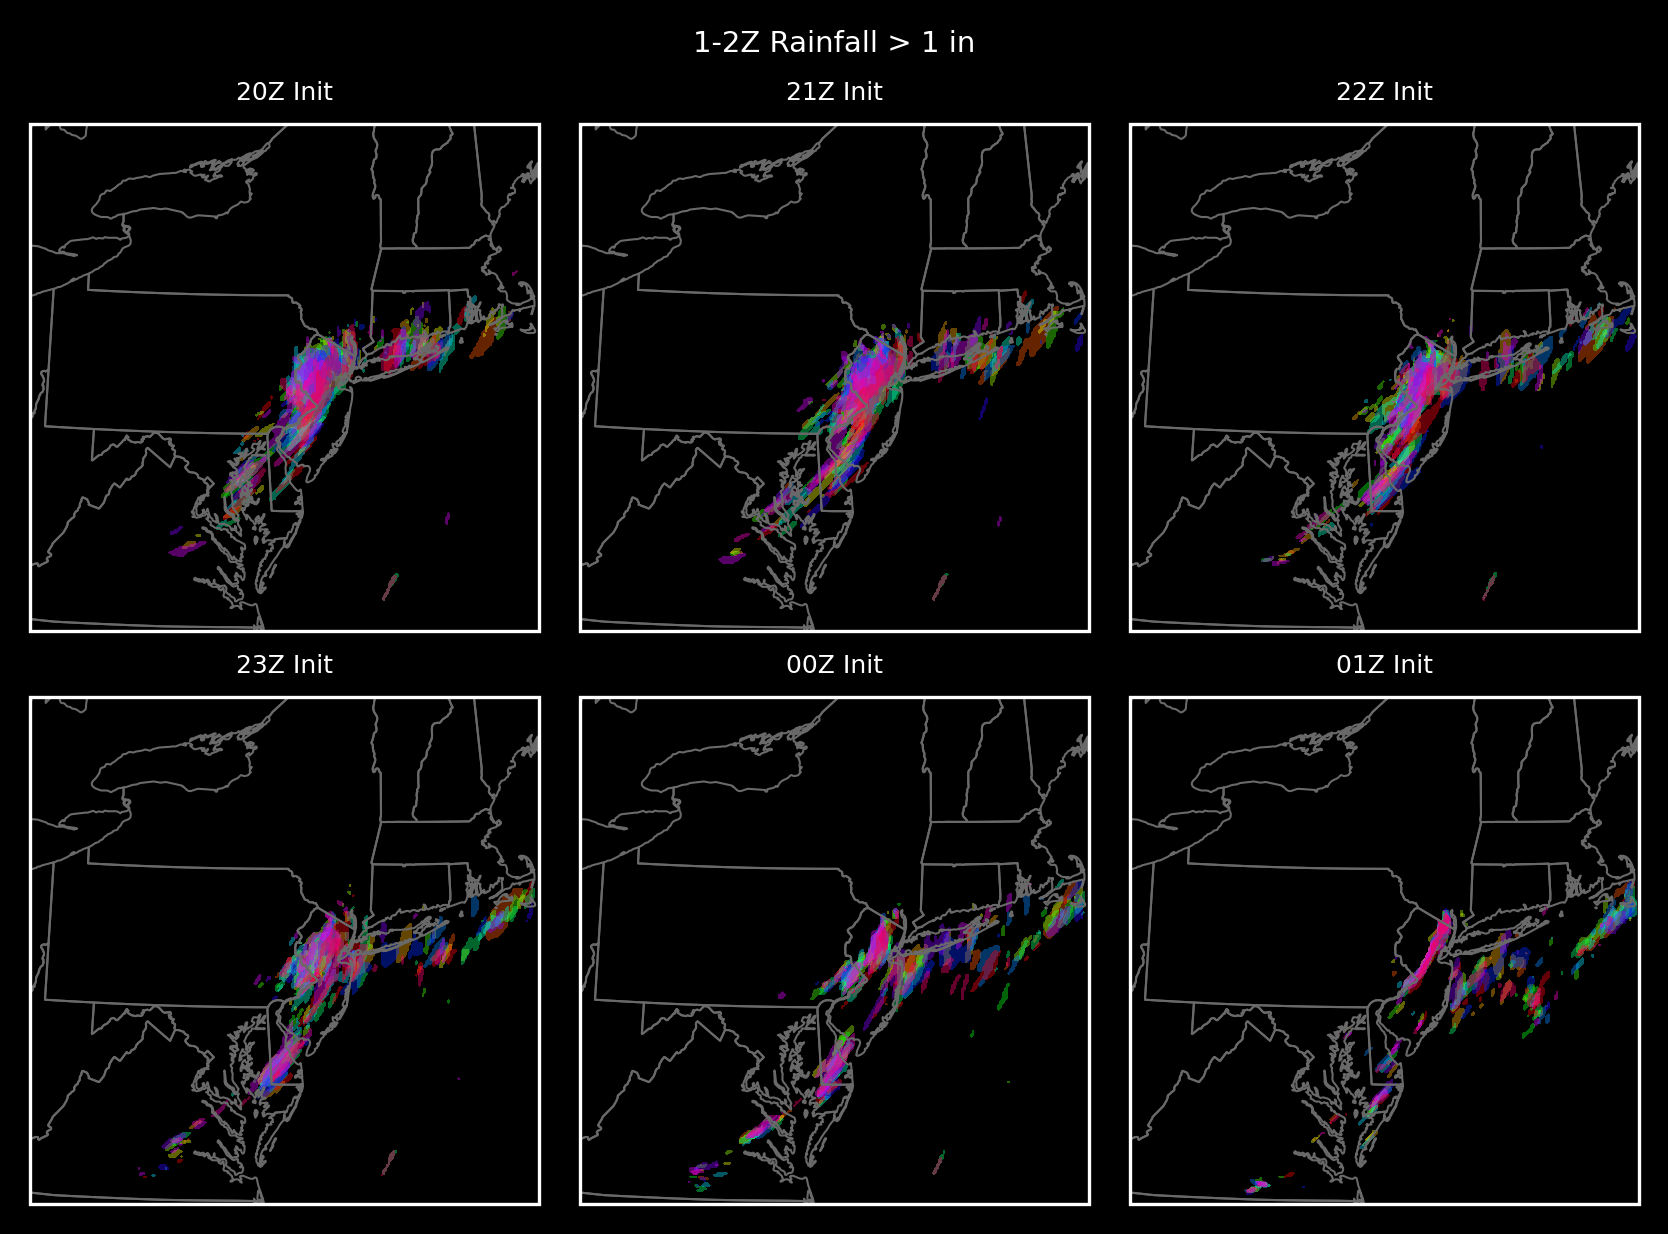

In [23]:
plt.style.use("dark_background")

linewidth=0.5
data_to_plot = gt1
titles = ["20Z Init","21Z Init","22Z Init","23Z Init","00Z Init","01Z Init"]
lat=rainnc_20Z.XLAT.isel(Time=0)
lon=rainnc_20Z.XLONG.isel(Time=0)

proj = ccrs.LambertConformal(central_longitude=rainnc_20Z.attrs['CEN_LON'],
                             central_latitude=rainnc_20Z.attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(5.5,4))

for i,ax in enumerate(axes.flatten()):
    for e in range(len(data_to_plot[i].ens)):
        p = ax.contourf(lon,lat,gt1[i].isel(ens=e),
                        transform=ccrs.PlateCarree(),
                        levels=[0.5,1.5],
                        colors=[colors[e]],alpha=0.4
        )
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="dimgray")
    ax.set_title(titles[i],fontsize=6)

plt.suptitle("1-2Z Rainfall > 1 in",fontsize=7)
plt.show()

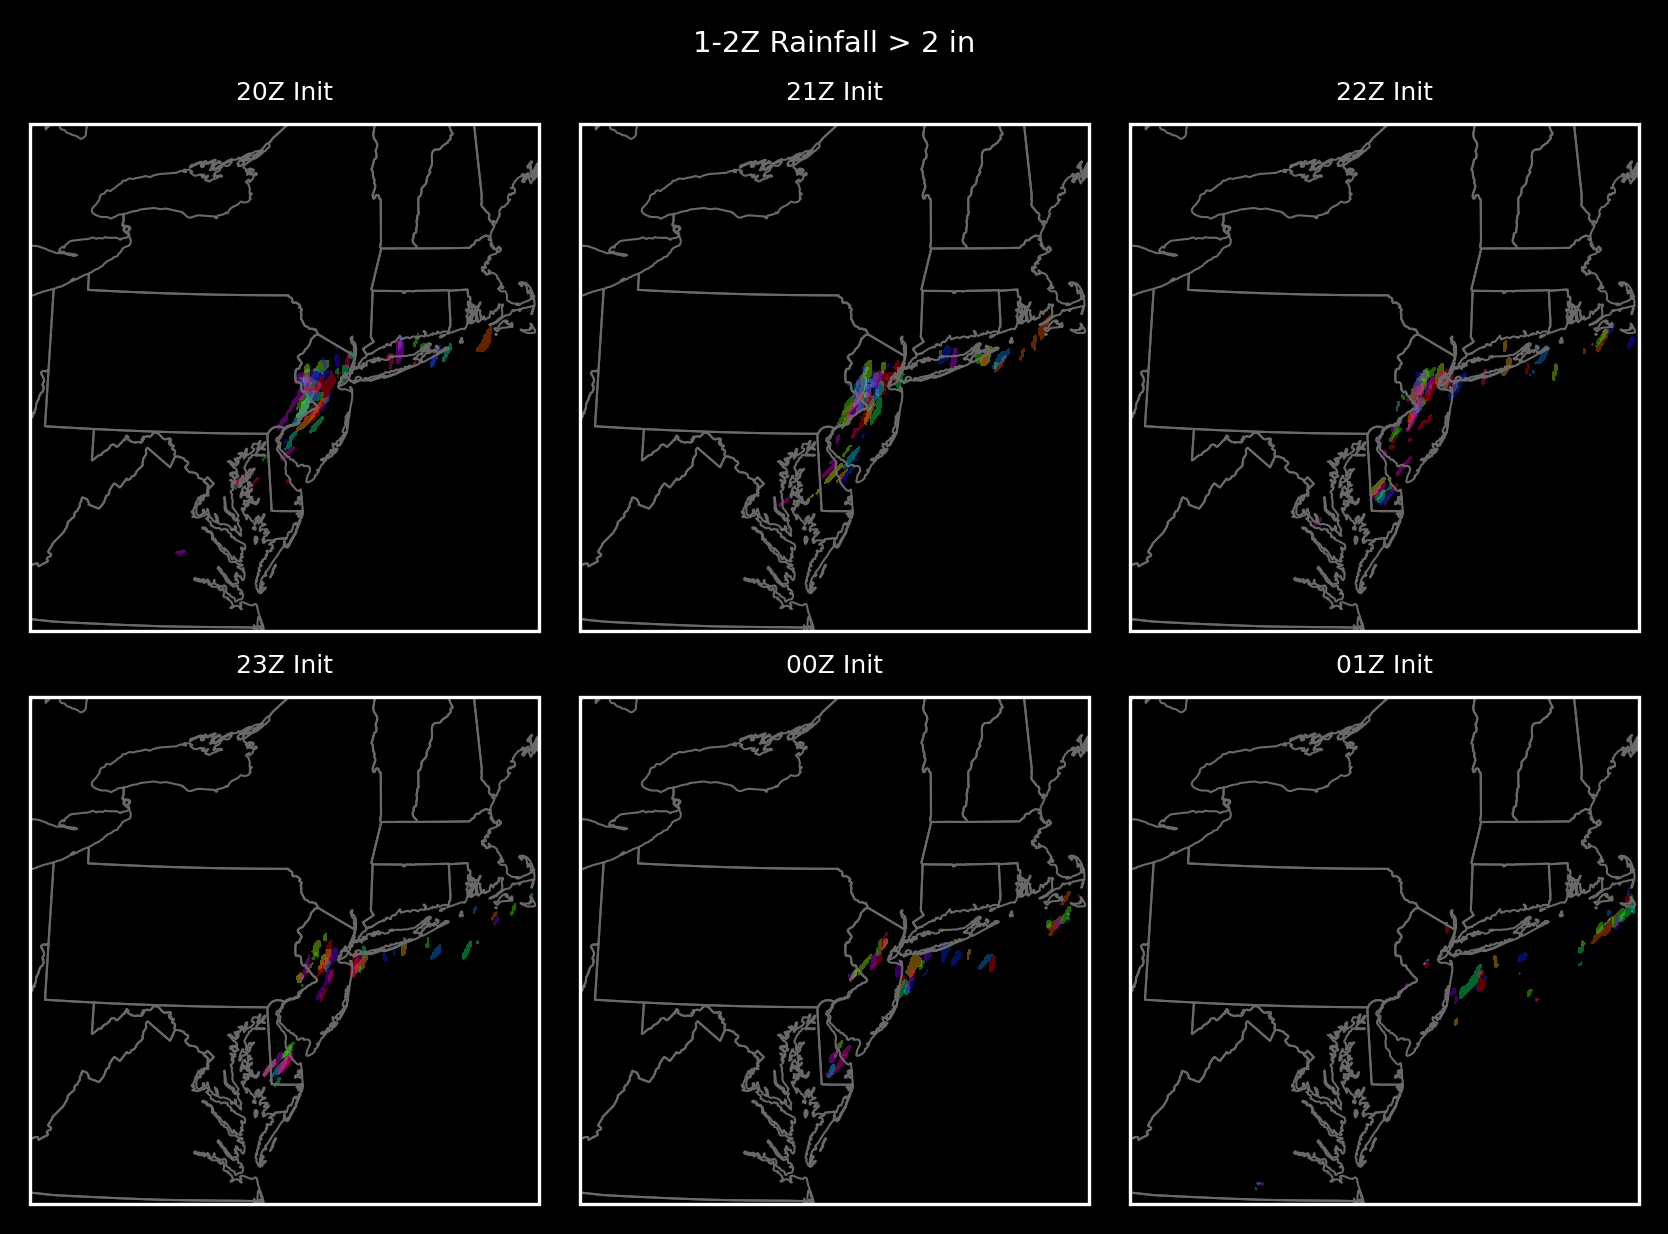

In [24]:
plt.style.use("dark_background")

linewidth=0.5
data_to_plot = gt2
titles = ["20Z Init","21Z Init","22Z Init","23Z Init","00Z Init","01Z Init"]
lat=rainnc_20Z.XLAT.isel(Time=0)
lon=rainnc_20Z.XLONG.isel(Time=0)

proj = ccrs.LambertConformal(central_longitude=rainnc_20Z.attrs['CEN_LON'],
                             central_latitude=rainnc_20Z.attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(5.5,4))

for i,ax in enumerate(axes.flatten()):
    for e in range(len(data_to_plot[i].ens)):
        p = ax.contourf(lon,lat,data_to_plot[i].isel(ens=e),
                        transform=ccrs.PlateCarree(),
                        levels=[0.5,1.5],
                        colors=[colors[e]],alpha=0.4
        )
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="dimgray")
    ax.set_title(titles[i],fontsize=6)

plt.suptitle("1-2Z Rainfall > 2 in",fontsize=7)
plt.show()

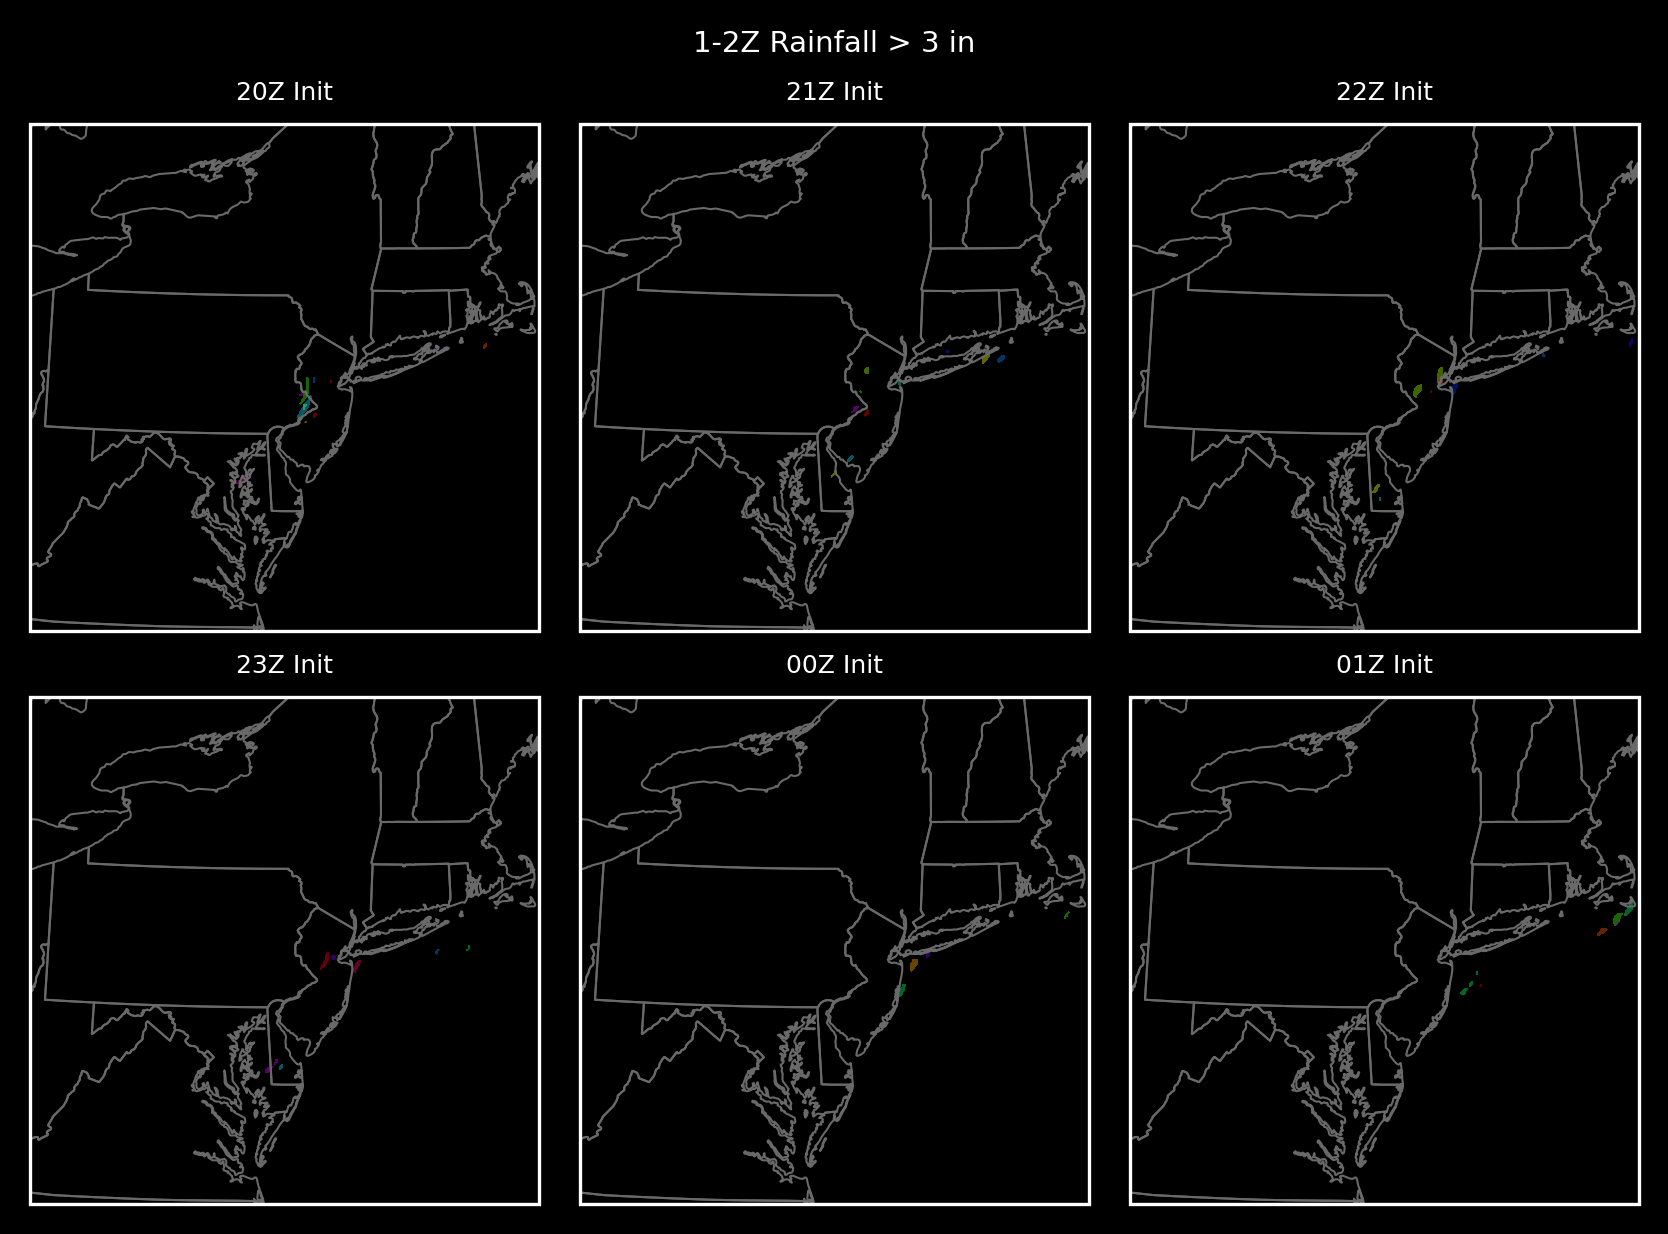

In [25]:
plt.style.use("dark_background")

linewidth=0.5
data_to_plot = gt3
titles = ["20Z Init","21Z Init","22Z Init","23Z Init","00Z Init","01Z Init"]
lat=rainnc_20Z.XLAT.isel(Time=0)
lon=rainnc_20Z.XLONG.isel(Time=0)

proj = ccrs.LambertConformal(central_longitude=rainnc_20Z.attrs['CEN_LON'],
                             central_latitude=rainnc_20Z.attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(5.5,4))

for i,ax in enumerate(axes.flatten()):
    for e in range(len(data_to_plot[i].ens)):
        p = ax.contourf(lon,lat,data_to_plot[i].isel(ens=e),
                        transform=ccrs.PlateCarree(),
                        levels=[0.5,1.5],
                        colors=[colors[e]],alpha=0.4
        )
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="dimgray")
    ax.set_title(titles[i],fontsize=6)

plt.suptitle("1-2Z Rainfall > 3 in",fontsize=7)
plt.show()